____
____
# Contoso Customer Analysis
____
____

____
## Introduction
____

__Problem Statement:__\
The Sales and Marketing Department in Contoso Corporation (a compnay that sells sport bikes related products) has the sales records from different countries through out multiple years. The excustives in the Sales & Marketing department want to undersatnd their potential and existing customers better. They want to get insights from the data about the characterisitcs of their best potential customers and  identify their best existing customers so they can customize their marketing compaign accordingly. 


__Objecttives:__
- To identify the characteristics of the best potential customers.
- To answer specific business questions.
- To rank the exisitng customers based on their Recency, Frequency and Monetary scores.


## Importing the Required Libraries

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import ipywidgets
from numpy import mean

from IPython.display import display_html
from itertools import chain,cycle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gc

____
## Data Discovery & Collection
____

In [2]:
# import the sales tables from folder
path = r'../data/Sales'
sales_files = glob.glob(path+'/*.csv')
sales_list = []
for file in sales_files:
    df = pd.read_csv(file, index_col = None, header= 0)
    sales_list.append(df)
sales = pd.concat(sales_list, axis = 0, ignore_index = True)
# import products table from csv file
products = pd.read_csv('../data/Contoso_Products.csv')
# import the customers table from csv file
customers = pd.read_csv('../data/Contoso_Customers.csv', encoding= 'unicode_escape')
#import territories table from csv file
territories = pd.read_csv('../data/Contoso_Territories.csv')


# make a list for tables
tables_list = [sales,products,customers,territories]

# iterate over the tables-list and print info for each
for table in tables_list:
    print(table.info(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50466 entries, 0 to 50465
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OrderDate      50466 non-null  object
 1   StockDate      50466 non-null  object
 2   OrderNumber    50466 non-null  object
 3   ProductKey     50466 non-null  int64 
 4   CustomerKey    50466 non-null  int64 
 5   TerritoryKey   50466 non-null  int64 
 6   OrderLineItem  50466 non-null  int64 
 7   OrderQuantity  50466 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.1+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ProductKey             293 non-null    int64  
 1   ProductSubcategoryKey  293 non-null    int64  
 2   ProductSKU             293 non-null    object 
 3   ProductName            293 non-null

Total Customers vs. Sales Customers

In [3]:
totalCustomers = customers['CustomerKey'].count()
print(f'There are total of {totalCustomers} customer in the "customer" table')

There are total of 18018 customer in the "customer" table


In [4]:
salesCustomers = sales['CustomerKey'].drop_duplicates().count()
print(f'There are total of {salesCustomers} customer in the "sales" table')

There are total of 15599 customer in the "sales" table


In order to analyze the relationship between the customer demographics and revenue, I will join the customers dataframe with the sales dataframe using 'inner join'. Since each customer in the sales table is also in the customer table, the total number of rows of the merged table should be equal to the sales table with only 15599 distinct.

However, before merging the 'customers' and the 'sales' dataframes, I should add the 'Revenue' column to the 'sales' dataframe. The 'Revenue' is the result of multiplying the 'ProductPrice' with the 'OrderQuantity'. The 'ProductPrice' exists in the 'products' dataframe. Therefore, I should first extract the 'ProductPrice' column from the 'products' dataframe and add it to the 'sales' table.

____
## Data Preparation
____

In [5]:
# merge the sales dataframe with the products data frame and assign that to sales_product
sales_products = sales.merge(
    products[['ProductKey','ProductPrice']],left_on = 'ProductKey', right_on = 'ProductKey')

sales_products['Revenue'] = round(sales_products['ProductPrice']*sales_products['OrderQuantity'],2)
 
sales_products.head(2)

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,ProductPrice,Revenue
0,1/1/2015,9/21/2001,SO45080,332,14657,1,1,1,699.0982,699.1
1,2/6/2015,10/12/2001,SO45383,332,14734,1,1,1,699.0982,699.1


In [6]:
# merge the sales_products dataframe with the customer dataframe and assign it to customer_analysis_df
customer_analysis= sales_products.merge(customers, left_on = 'CustomerKey', right_on='CustomerKey')


In [7]:
# add 'Customer' column which include the customer's 'FirstName' and 'lastName'
customer_analysis['Customer'] = customer_analysis['FirstName']+' '+customer_analysis['LastName']
# Capitalize the 'Customer' column
customer_analysis['Customer'] = [name.title() for name in customer_analysis['Customer'].values]
# delete the 'FirstName' and 'LastName' columns
customer_analysis.drop(['FirstName','LastName'], axis = 1, inplace = True)
# clean the 'AnnualIncome' column by removing the $ sign and convert its data type into intger
customer_analysis['AnnualIncome'] = customer_analysis['AnnualIncome'].str.split('$').str.get(1).str.replace(',','').astype('int')
# convert the 'orderDate' and 'birthDate' column into datetime dataframe
customer_analysis['OrderDate'] = pd.to_datetime(customer_analysis['OrderDate'])
customer_analysis['BirthDate'] = pd.to_datetime(customer_analysis['BirthDate'])


It would be better to analyze the csutomers Annual Income as a level representing range of values rather than individual integer values.

In [8]:
def annual_income_level(x):
    if x < 40000:
        return 'Low Income Level'
    elif x <= 80000:
        return 'Medium Income Level'
    elif x > 80000:
        return 'High Income Level'

customer_analysis['IncomeLevel'] = customer_analysis['AnnualIncome'].\
                                     apply(lambda x : annual_income_level(x))

There are 3 options to analyze the age of the customers:

1- Based on the 'BirthDate' column and present day.\
2- Based on the 'BirthDate' column and 'OrderDate'.\
3- Assuming the present date is the last (maximum) date in the data and then find the customer age based on the 'BirthDate' and present date.

since, the data time-frame is 2015-2017, the first option won't provide an accurate representation for the customer age.

The second option may provide 1, 2 or 3 different ages for a given customer. For example, if the customer made a purchase in 2015, the customer's age will be the result of deducting the 'OrderDate' minus 'BirthDate', and if the same customer made another purchase in 2016, then the same customer's age will increase by 1 year. This can be confusing, but it may also be useful for studying the association of the age range/group with the purchase habits/power.

The third option provide the age of the customer assuming that the latest date of data is the present date. This is useful for studying the current demographics of the customers.

So, I will use 2 age columns for option 1 and option 2.

In [9]:
customer_analysis['AgeBasedOnOrderDate'] = (
                customer_analysis['OrderDate'].dt.year - customer_analysis['BirthDate'].dt.year)

customer_analysis['AgeBasedOnPresentDate'] = (
            customer_analysis['OrderDate'].dt.year.max() - customer_analysis['BirthDate'].dt.year)

In [10]:
print(f"Maximum age based on order date is {customer_analysis['AgeBasedOnOrderDate'].max()}")
print(f"Minimum age based on order date is {customer_analysis['AgeBasedOnOrderDate'].min()}")
print('\n')
print(f"Maximum age based on present date is {customer_analysis['AgeBasedOnPresentDate'].max()}")
print(f"Minimum age based on present date is {customer_analysis['AgeBasedOnPresentDate'].min()}")

Maximum age based on order date is 107
Minimum age based on order date is 35


Maximum age based on present date is 107
Minimum age based on present date is 37


In [11]:
# assuming that no customer will be less than 14 years old, make a function to assign the age groups for
# the two age columns
def age_group_order_date(x):
    if x < 20:
        return '14-19'
    elif x < 40:
        return '20-39'
    elif x < 60:
        return '40-59'
    elif x < 80:
        return '60-79'
    elif x < 100:
        return '80-99'
    else:
        return '>= 100'
    
    
customer_analysis['AgeGroup_BasedOnOrderDate'] = customer_analysis['AgeBasedOnOrderDate'].\
                        apply(lambda x: age_group_order_date(x))

customer_analysis['AgeGroup_BasedOnPresentDate'] = customer_analysis['AgeBasedOnPresentDate'].\
                        apply(lambda x: age_group_order_date(x))

In order to get the customers' locations information, I should merge the customer_analysis_df with the territory dataframe.

In [12]:
customer_analysis = customer_analysis.merge(
    territories, left_on = 'TerritoryKey', right_on = 'SalesTerritoryKey')

In [13]:
def region_function(x):
    if x == 'Southwest':
        return 'USA-SW'
    elif x == 'Northwest':
        return 'USA-NW'
    elif x == 'Southeast':
        return 'USA-SE'
    elif x == 'Northeast':
        return 'USA-NE'
    elif x == 'Central':
        return 'USA-C'
    else:
        return x
    
customer_analysis['Region'] = customer_analysis['Region'].apply(lambda x :  region_function(x))

Optimize the RAM usage by converting repeated values of string data types into category data type and deleting the unnecessary dataframes

In [14]:
# delete tthe unnecessary columns
customer_analysis.drop(
    ['StockDate','TerritoryKey','SalesTerritoryKey','EmailAddress','Prefix','ProductPrice','OrderLineItem',
     'BirthDate'], axis = 1, inplace = True)

# delete the sales_products dataframe
del sales_products

# convert the object columns with repeated values into category type
cols_names = [str(col) for col in customer_analysis.columns]

for col in cols_names:
    if (customer_analysis[col].dtype == 'O') & (len(customer_analysis[col].value_counts()) < 20):
        customer_analysis[col] = customer_analysis[col].astype('category')

In [15]:
customer_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50466 entries, 0 to 50465
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   OrderDate                    50466 non-null  datetime64[ns]
 1   OrderNumber                  50466 non-null  object        
 2   ProductKey                   50466 non-null  int64         
 3   CustomerKey                  50466 non-null  int64         
 4   OrderQuantity                50466 non-null  int64         
 5   Revenue                      50466 non-null  float64       
 6   MaritalStatus                50466 non-null  category      
 7   Gender                       50466 non-null  category      
 8   AnnualIncome                 50466 non-null  int32         
 9   TotalChildren                50466 non-null  int64         
 10  EducationLevel               50466 non-null  category      
 11  Occupation                   50466 non-nu

________
## Basic Cusotmer Analysis
____

The basic customer analysis will be based on the dempographics of the customer and the relationship between the demograpics and revenue. This analysis can come helpful in indentifying the characteristics of potential customers. Demographics include;

- Gender.
- Marital Status.
- Education Level.
- Occupation.
- Homeownership.
- Country.
- Number of Total Children.
- Annual Income Level.
- Age Group.

__Making Functions__

In the next analysis, I will aggregate revenue by customer key and each categorical columns. Next, I will count the number of customer of each category in the categorical columns and display them using using charts. Then, I will calculate and display the basics statistics of each category in the categorical columns and display them side by side. Moreover,  Furthermore, I will aggregate the revenue of each category in the categorical columns and display that in multiple cahrt figures. In order not to repeat the code, I 'll make following functions:

- make_customer_category_rev_df():\
a function that takes a dataframe and a name of a categorical column then aggreagte the dataframe by "CustomerKey" and the categorical column to add the "TotalRevenue".
- make_customer_count():\
a function that takes in a dataframe and one of its categorical columns' name then calculates the customer count for each category in a categorical column.
- make_count_vis():\
a function that takes in a dataframe and a title then visualizes the customers count for each category in a column in bar chart and their percentage in and pie chart.
- display_side_by_side(): \
 a function that takes in a list of dataframes and their titles then displays them side by side.
- make_basic_stats():\
a function that takes in a dataframe and one of its categorical columns' name then calculates the basic statistics for the revenue of each category in a categorical column then uses display_side_by_side to display the dataframes of the basic statistics side by side.
- make_agg_rev():\
a function that takes in a dataframe and a categorical column name then aggregates the  Revenue of each category in the column and return dataframe that includes Total Revenue, Average Revenue and Medain Revenue.
- make_rev_vis():\
a function that takes in 2 dataframes, a title and a categorical column name then visualizes the Total Revenue, Average Revenue and Median Revenue of each category in the column in multiple charts.

In [16]:
def make_customer_category_rev_df(df,col):
    """a function that takes a dataframe and a name of a categorical column then aggreagte the dataframe 
    by "CustomerKey" and the categorical column to add the "TotalRevenue"."""
    customer_category_rev_df = df.groupby(['CustomerKey',col]).\
                                agg({'Revenue':'sum'}).reset_index().\
                                rename(columns = {'Revenue':'TotalRevenue'})
    
    customer_category_rev_df = customer_category_rev_df[customer_category_rev_df['TotalRevenue']!=0]
    
    if col == 'AgeGroup_BasedOnPresentDate':
        customer_category_rev_df.rename(columns = {'AgeGroup_BasedOnPresentDate':'AgeGroup'}, inplace = True)
    if col == 'AgeGroup_BasedOnOrderDate':
        customer_category_rev_df.rename(columns = {'AgeGroup_BasedOnOrderDate':'AgeGroup'}, inplace = True)     
    if col == 'TotalChildren':
        customer_category_rev_df[col] =  customer_category_rev_df[col].astype('str')
    return customer_category_rev_df

In [17]:
def make_customer_count(df,col):
    """a function that takes in a dataframe and one of its categorical columns' name then calculates the 
    customer count for each category in a categorical column."""
    df_count = df.groupby(col).agg({'CustomerKey':'count'}).\
                rename(columns = {'CustomerKey':'CustomersCount'}).\
                sort_values('CustomersCount', ascending =False)
    if col == 'AgeGroup':
         df_count.drop('>= 100',axis=0, inplace=True)
    return df_count

In [18]:
# write a function that display the customers count per category
def make_count_vis(df,title):
    """a function that takes in a dataframe and a title then visualizes the customers count for each category
    in a column in bar chart and their percentage in and pie chart."""
    print(df)
    chart_order = df.index
    
    
    if title == 'Occupation':
        explode_list = [0,0,0,0,0.11]  
    elif title == 'Age group':
        explode_list = [0,0,0,0.14]
    elif title == 'Region':
        explode_list = [0,0,0.11]
    else:
        explode_list =[]
        for i in range(len(df.index)):
            explode_list.append(0)
      
    plt.figure(figsize = (18,6), facecolor = 'lightblue')
    plt.suptitle(f'Number of Customers by {title}', size = 22)
    
    plt.subplot(1,2,1)
    sns.barplot(x = df.index, y= 'CustomersCount', data = df, order = chart_order )
#     plt.title(f'{title} by Count', size = 18)
    plt.xticks(size = 14)
    plt.xlabel(f'{title}', size = 18)
    plt.ylabel('Count of Customers',size = 18)
    plt.yticks(size = 18)
    
    plt.subplot(1,2,2)
    if len(df.index) == 2:
        plt.pie(x = df['CustomersCount'],
                labels = df.index,
                startangle= 90,
                counterclock= False,
                textprops={'fontsize': 14},
                autopct= '%2.1F%%')
        
    else:
        plt.pie(x = df['CustomersCount'],
                labels = df.index,
                startangle= 90,
                counterclock= False,
                textprops={'fontsize': 14},
                autopct= '%2.1F%%',
                explode = explode_list       
               )
#         plt.title(f'{title} by Percentage of Total', size = 18)
        
        circle = plt.Circle((0,0), 0.78, color = 'white')
        get_current_figure = plt.gcf()
        get_current_figure.gca().add_artist(circle)

        plt.tight_layout()
        plt.show()

In [19]:
# write a function to display tables horizontally with their titles
def display_side_by_side(*args,titles=cycle([''])):
    """a function that takes in a list of dataframes and their titles then displays them side by side."""
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h6>{title}</h6>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# write a function to calculate the basic statistics of a revenue vs. a categories and display the output
def make_basic_stats(df,col):
    """a function that takes in a dataframe and one of its categorical columns' name then calculates the basic 
    statistics for the revenue of each category in a categorical column then uses display_side_by_side to display the dataframes of the basic statistics side by side."""
    categories_list = df[col].value_counts().index
    if col == 'AgeGroup':
        categories_list = ['20-39','40-59','60-79','80-99','>= 100']
    names = []
    stats_list = []
    for category in categories_list:
        name = category+ ' Revenue Statistics'
        names.append(name)
        category_stats = df[df[col] == category]['TotalRevenue'].describe().to_frame()
        stats_list.append(category_stats)
    if col == 'HomeOwner':
        names = ['Homowners Revenue Statistics','Non-Homeowners Revenue Statistics']
    if col == 'Gender':
        names = ['Males Revenue Statistics','Females Revenue Statistics']
    display_side_by_side(*stats_list, titles = names)

In [20]:
# make_rev_agg
def make_agg_rev(df, col):
    """a function that takes in a dataframe and a categorical column name then aggregates the Revenue of each 
    category in the column and return dataframe that includes Total Revenue, Average Revenue and Medain Revenue."""
    df_agg_rev = df.groupby(col).agg({'TotalRevenue':['sum','mean','median']})
    df_agg_rev = df_agg_rev['TotalRevenue'].\
                rename(columns = {'sum':'TotalRevenue','mean':'AverageRevenue','median':'MedianRevenue'}).\
                sort_values('AverageRevenue', ascending = False)
    if col == 'AgeGroup':
         df_agg_rev.drop('>= 100',axis=0, inplace=True)
    return df_agg_rev
    

In [21]:
# make_rev_vis
def make_rev_vis(df1,df2,title,col):
    """a function that takes in 2 dataframes, a title and a categorical column name then visualizes the Total 
    Revenue, Average Revenue and Median Revenue of each category in the column in multiple charts."""
    print(df1)
    chart_order = df1.index
    
    if (title == 'Education Level') | (title =='Occupation'):
        explode_list = [0,0,0,0,0.11]
    elif title =='Region':
        explode_list = [0,0.14,0,-0.1,0.14]
    elif title == 'Age Group':
        explode_list = [0,0,0,0.14]
    else:
        explode_list = None

    fig = plt.figure(figsize=(26,20),  facecolor = 'lightblue')
    plt.suptitle(f'Revenue by {title}', size = 22)

    plt.subplot(3,2,1)
    sns.barplot(x=df1.index, y='TotalRevenue', data=df1, order = chart_order)
    plt.title(f'Total Revenue by {title}', size =18)
    plt.xlabel(f'{title}', size = 18)
    plt.ylabel('Total Revenue', size=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)

    plt.subplot(3,2,2)
    plt.pie(x = df1['TotalRevenue'],
            labels = df1.index,
            radius= 1.1,
            startangle= 90,
            counterclock= False,
            autopct= '%2.1F%%',
            textprops={'fontsize': 18},
            explode = explode_list
           )
    circle = plt.Circle((0,0), 0.9, color = 'white')
    get_current_figure = plt.gcf()
    get_current_figure.gca().add_artist(circle)

    plt.subplot(3,2,3)
    sns.barplot(x=df1.index, y='AverageRevenue', data=df1, order = chart_order)
    plt.title(f'Average Revenue by {title}', size =18)
    plt.xlabel(f'{title}', size = 18)
    plt.ylabel('Average Revenue', size=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)

    plt.subplot(3,2,4)
    sns.barplot(x=df1.index, y='MedianRevenue', data=df1, order = chart_order)
    plt.title(f'Median Revenue by {title}', size =18)
    plt.xlabel(f'{title}', size = 18)
    plt.ylabel('Median Revenue', size=18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)

    plt.subplot(3,2,5)
    sns.boxplot(x='TotalRevenue', y=col, data=df2, order = chart_order)                          
    plt.title(f'Revenue Distribution by {title}', size = 18)
    plt.xlabel('Total Revenue', size =18)
    plt.ylabel('Total Children', size = 18)
    plt.xticks(size = 18)
    plt.yticks(size = 18, rotation = 60)
    
    plt.subplot(3,2,6)
    ax6 = sns.kdeplot(data = df2, x = 'TotalRevenue', hue=col)
    plt.title(f'Revenue Kde Distribution by {title}', size = 18)
    plt.xlabel('Total Revenue', size = 18)
    plt.ylabel('Density',size =18)
    plt.setp(ax6.get_legend().get_texts(), fontsize='18') 
    plt.setp(ax6.get_legend().get_title(), fontsize='22')

    plt.tight_layout()
    plt.show()


In [22]:
def make_stats_test(df1,df2,col):
    """a function that takes in 2 dataframes and categorical column then perform hypothesis testing on 
    the 'TotalRevenue' of 2 categorical values in the categorical column"""
    category1 = df2.index[0]
    val1 = df2['AverageRevenue'][0]
    category2 = df2.index[1]
    val2 = df2['AverageRevenue'][1]
    
    
    _,p_ev = stats.levene(
                df1[df1[col] == category1]['TotalRevenue'], 
                df1[df1[col] == category2]['TotalRevenue'], 
                center='mean')
    if p_ev > 0.05:
        equal_variance = True
    else:
        equal_variance = False
    
    s_avg,p_avg = stats.ttest_ind(
                df1[df1[col] == category1]['TotalRevenue'], 
                df1[df1[col] == category2]['TotalRevenue'],  
                equal_var = equal_variance)
    
    print('Statistics:',s_avg)
    print('P_value',p_avg)
    
    if col == 'TotalChildren':
        category1 = '1 child'
        category2 = '3 children'
    if col == 'HomeOwner':
        category1 = 'homeowner'
        category2 = 'non homeowner'
    if col == 'MaritalStatus':
        category1 = 'single'
        category2 = 'married'
    if col == 'Gender':
        category1 = 'female'
        category2 = 'male'
        
    if p_avg > 0.05:
        print(f"There is no significant evidence that {category1} customers spend more than {category2} customers on average")
    else:
        print(f"There is a significant evidence that {category1} customers spend more than {category2 } customers on average")

### Gender Analysis

#### What are the demographic of the customers and the relationship between the revenue and csutomers demographic ?

Each row of the customer_analysis_df dataframe represents an line item transaction. An order may consist of multiple line items. Since an order can have only one customer, it is associated with only one 'Gender' value. So, to get the exact number of customers, I will group data by 'CustomerKey' and 'Gender' so that each line represents 1 customer with the coresponding 'Gender' and total 'Revenue' . Since each customer can have only 'Gender' value, the revenue aggregation value for the wrong 'Gender' will be 0.

In [23]:
customer_gender_rev = make_customer_category_rev_df(customer_analysis,'Gender')
customer_gender_rev.head()

,CustomerKey,Gender,TotalRevenue
1,11000,M,4656.39
3,11001,M,2821.21
5,11002,M,4466.81
6,11003,F,4532.99
8,11004,F,4568.08


__Gender Demographic__

Customers by Gender Count

In [24]:
gender_count = make_customer_count(customer_gender_rev, 'Gender')
gender_count

,CustomersCount
Gender,
M,7904
F,7695


Customers by Gender Count Visualization

        CustomersCount
Gender                
M                 7904
F                 7695


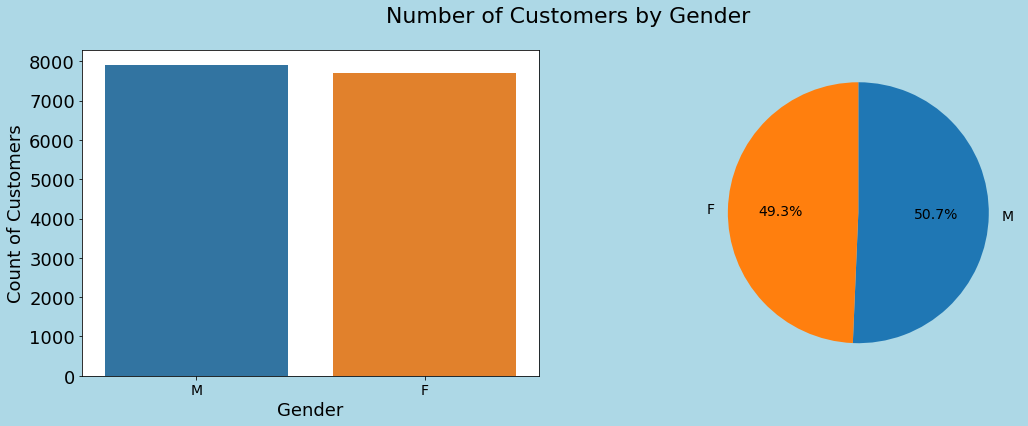

In [25]:
#  colors = ['blue','orange'],
make_count_vis(gender_count, 'Gender')

__Revenue by Gender__

Revenue by Gender Basic Statistics

In [26]:
make_basic_stats(customer_gender_rev,'Gender')

,TotalRevenue
count,7904.000000
mean,1394.104899
std,1843.813598
min,2.290000
25%,69.990000
50%,370.075000
75%,2214.160000
max,10165.920000
,TotalRevenue
count,7695.000000


Total, Average and Median Revenue Aggregation by Gender

In [27]:
rev_by_gender = make_agg_rev(customer_gender_rev,'Gender')
rev_by_gender

,TotalRevenue,AverageRevenue,MedianRevenue
Gender,,,
F,11390156.76,1480.202308,573.630
M,11019005.12,1394.104899,370.075


In [28]:
gender_list = ['All']+rev_by_gender.index.tolist()

Revenue by Gender Visualization

        TotalRevenue  AverageRevenue  MedianRevenue
Gender                                             
F        11390156.76     1480.202308        573.630
M        11019005.12     1394.104899        370.075


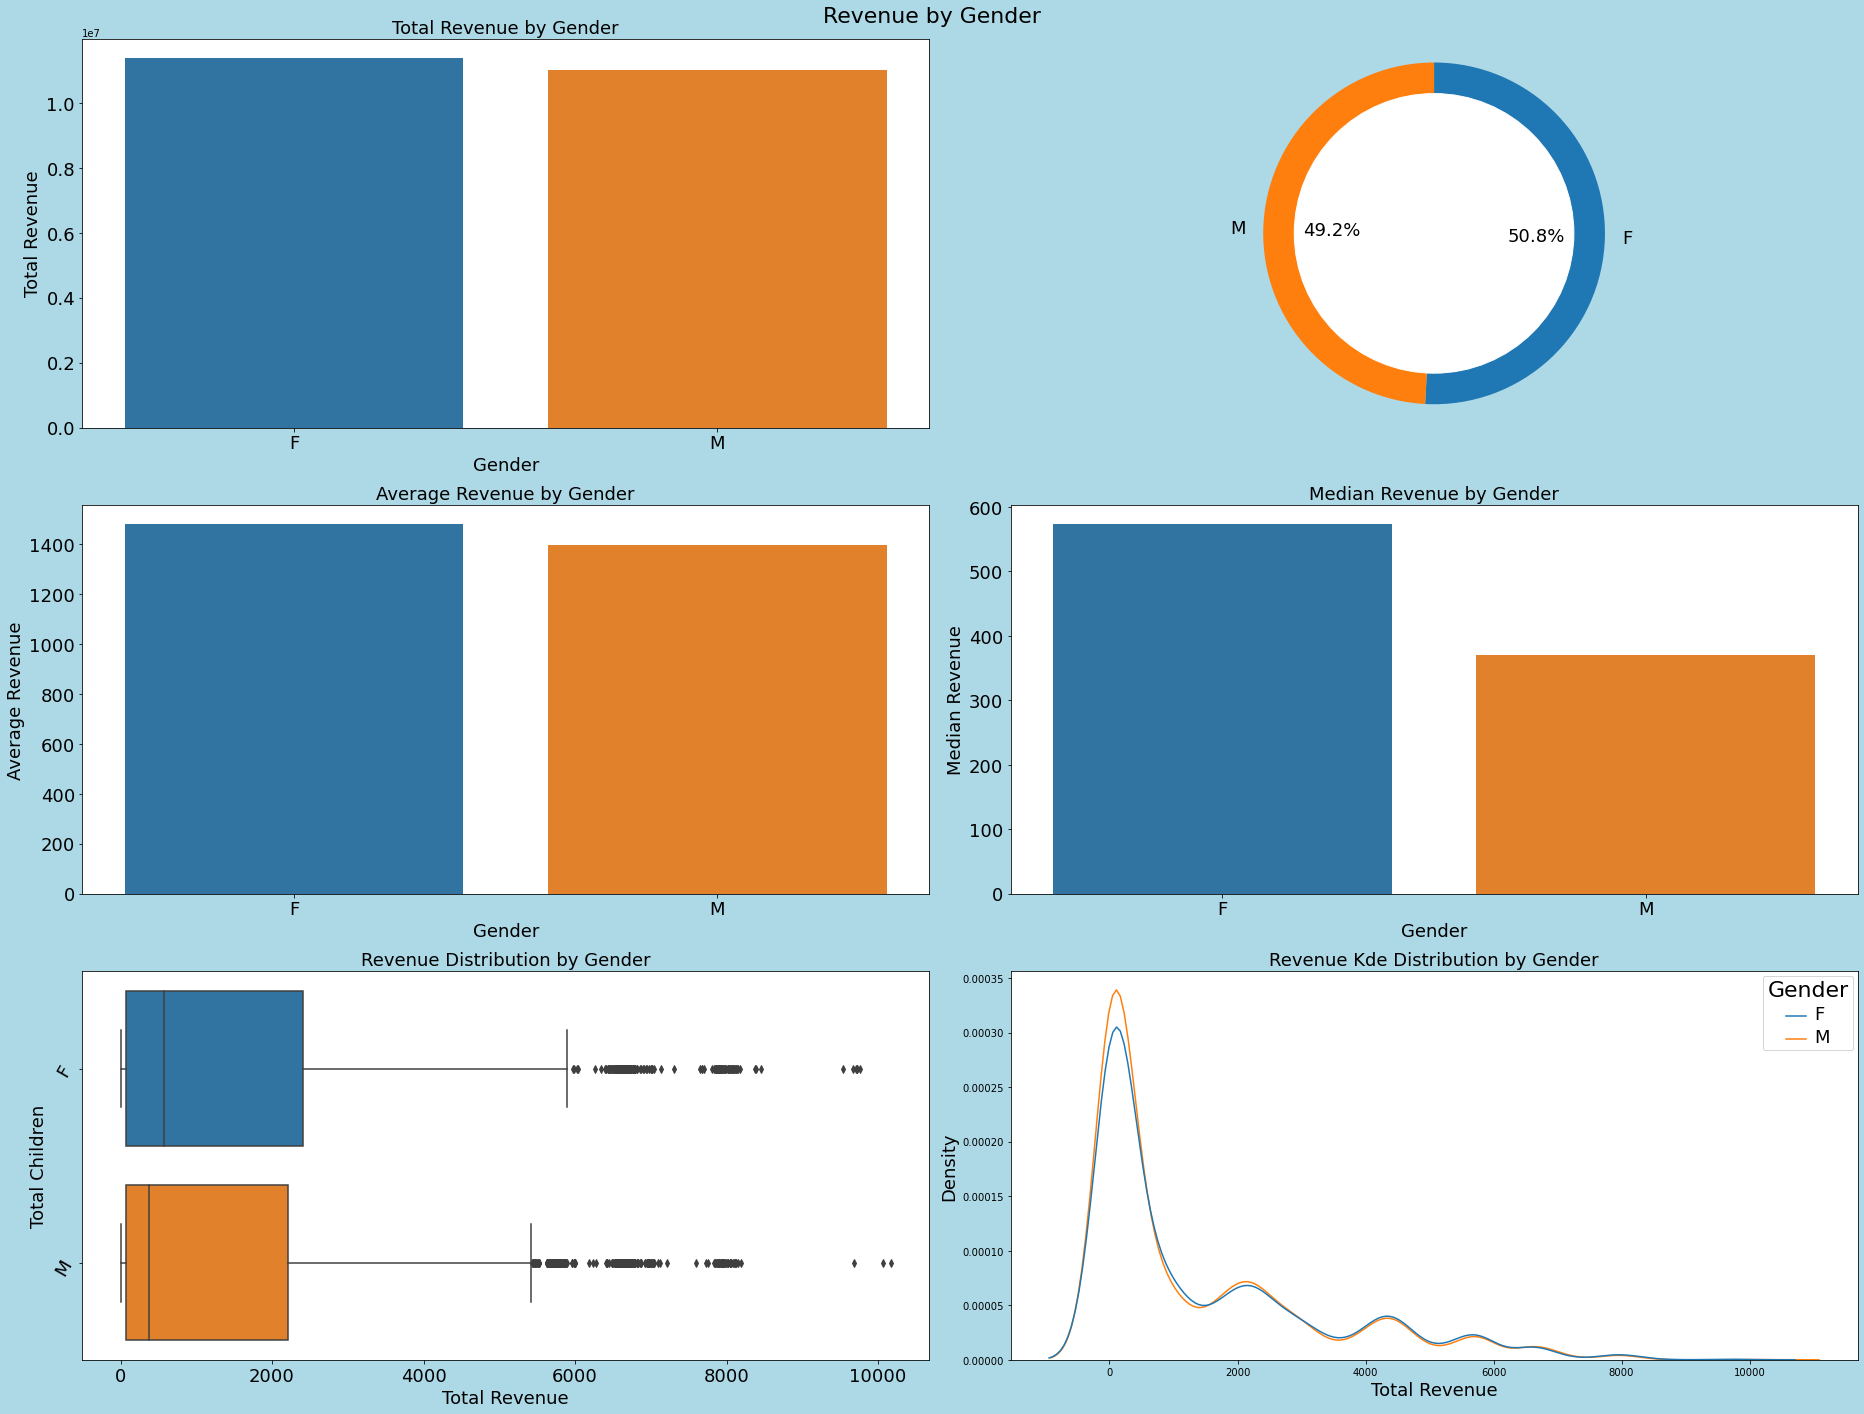

In [29]:
make_rev_vis(rev_by_gender,customer_gender_rev,'Gender','Gender')

Revenue vs.Gender Significance:

Assuiming that the data represents a sample of the customers population,is there a significant difference between the Gender categories in term of the total revenue on average? (On average, does the females customers spend more than the males customers?)

In [30]:
make_stats_test(customer_gender_rev,rev_by_gender,'Gender')

Statistics: 2.879681694228611
P_value 0.003986199622152465
There is a significant evidence that female customers spend more than male customers on average


__Inference__\
The number of males customers is slightly higher than females. However, females customers contribute more in the total Total, and spend more on average.

In [31]:
del (customer_gender_rev,
gender_count,
rev_by_gender)
gc.collect()

22242

### Marital Status Analysis

In [32]:
customer_maritalStatus_rev = make_customer_category_rev_df(customer_analysis,'MaritalStatus')
customer_maritalStatus_rev.head()

,CustomerKey,MaritalStatus,TotalRevenue
0,11000,M,4656.39
3,11001,S,2821.21
4,11002,M,4466.81
7,11003,S,4532.99
9,11004,S,4568.08


__Marital Status Demographic__

Customers by Marital Status Count

In [33]:
maritalStatus_count = make_customer_count(customer_maritalStatus_rev,'MaritalStatus')
maritalStatus_count

,CustomersCount
MaritalStatus,
M,8618
S,6981


Customers by Marital Status Count Visualization

               CustomersCount
MaritalStatus                
M                        8618
S                        6981


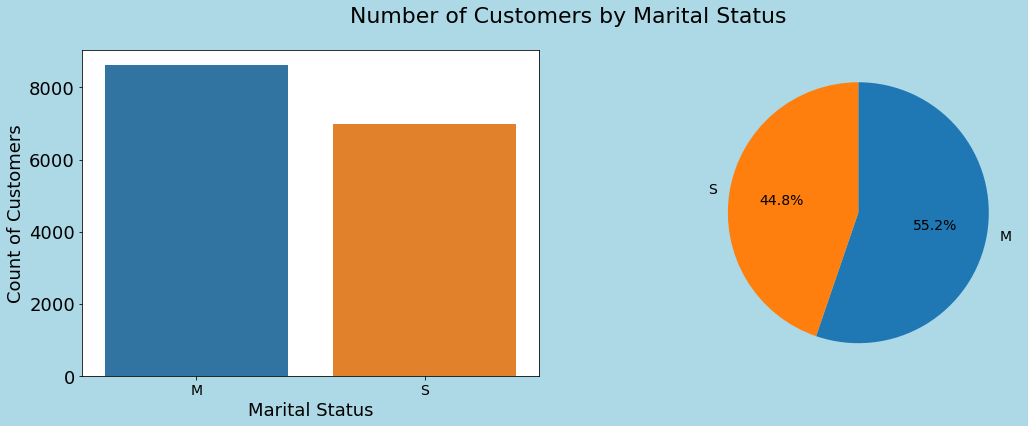

In [34]:
make_count_vis(maritalStatus_count,'Marital Status')

__Revenue By MaritalStatus__

Revenue by Marital Status Basic Statistics

In [35]:
make_basic_stats(customer_maritalStatus_rev,'MaritalStatus')

,TotalRevenue
count,8618.000000
mean,1342.808558
std,1833.024993
min,2.290000
25%,69.990000
50%,214.265000
75%,2181.145000
max,10165.920000
,TotalRevenue
count,6981.000000


Total, Mean and Median Revenue by Marital Status

In [36]:
rev_by_maritalStatus = make_agg_rev(customer_maritalStatus_rev,'MaritalStatus')
rev_by_maritalStatus

,TotalRevenue,AverageRevenue,MedianRevenue
MaritalStatus,,,
S,10836837.73,1552.333151,602.940
M,11572324.15,1342.808558,214.265


In [37]:
maritalStatus_list = ['All']+rev_by_maritalStatus.index.tolist()

Revenue by Marital Status Visualization

               TotalRevenue  AverageRevenue  MedianRevenue
MaritalStatus                                             
S               10836837.73     1552.333151        602.940
M               11572324.15     1342.808558        214.265


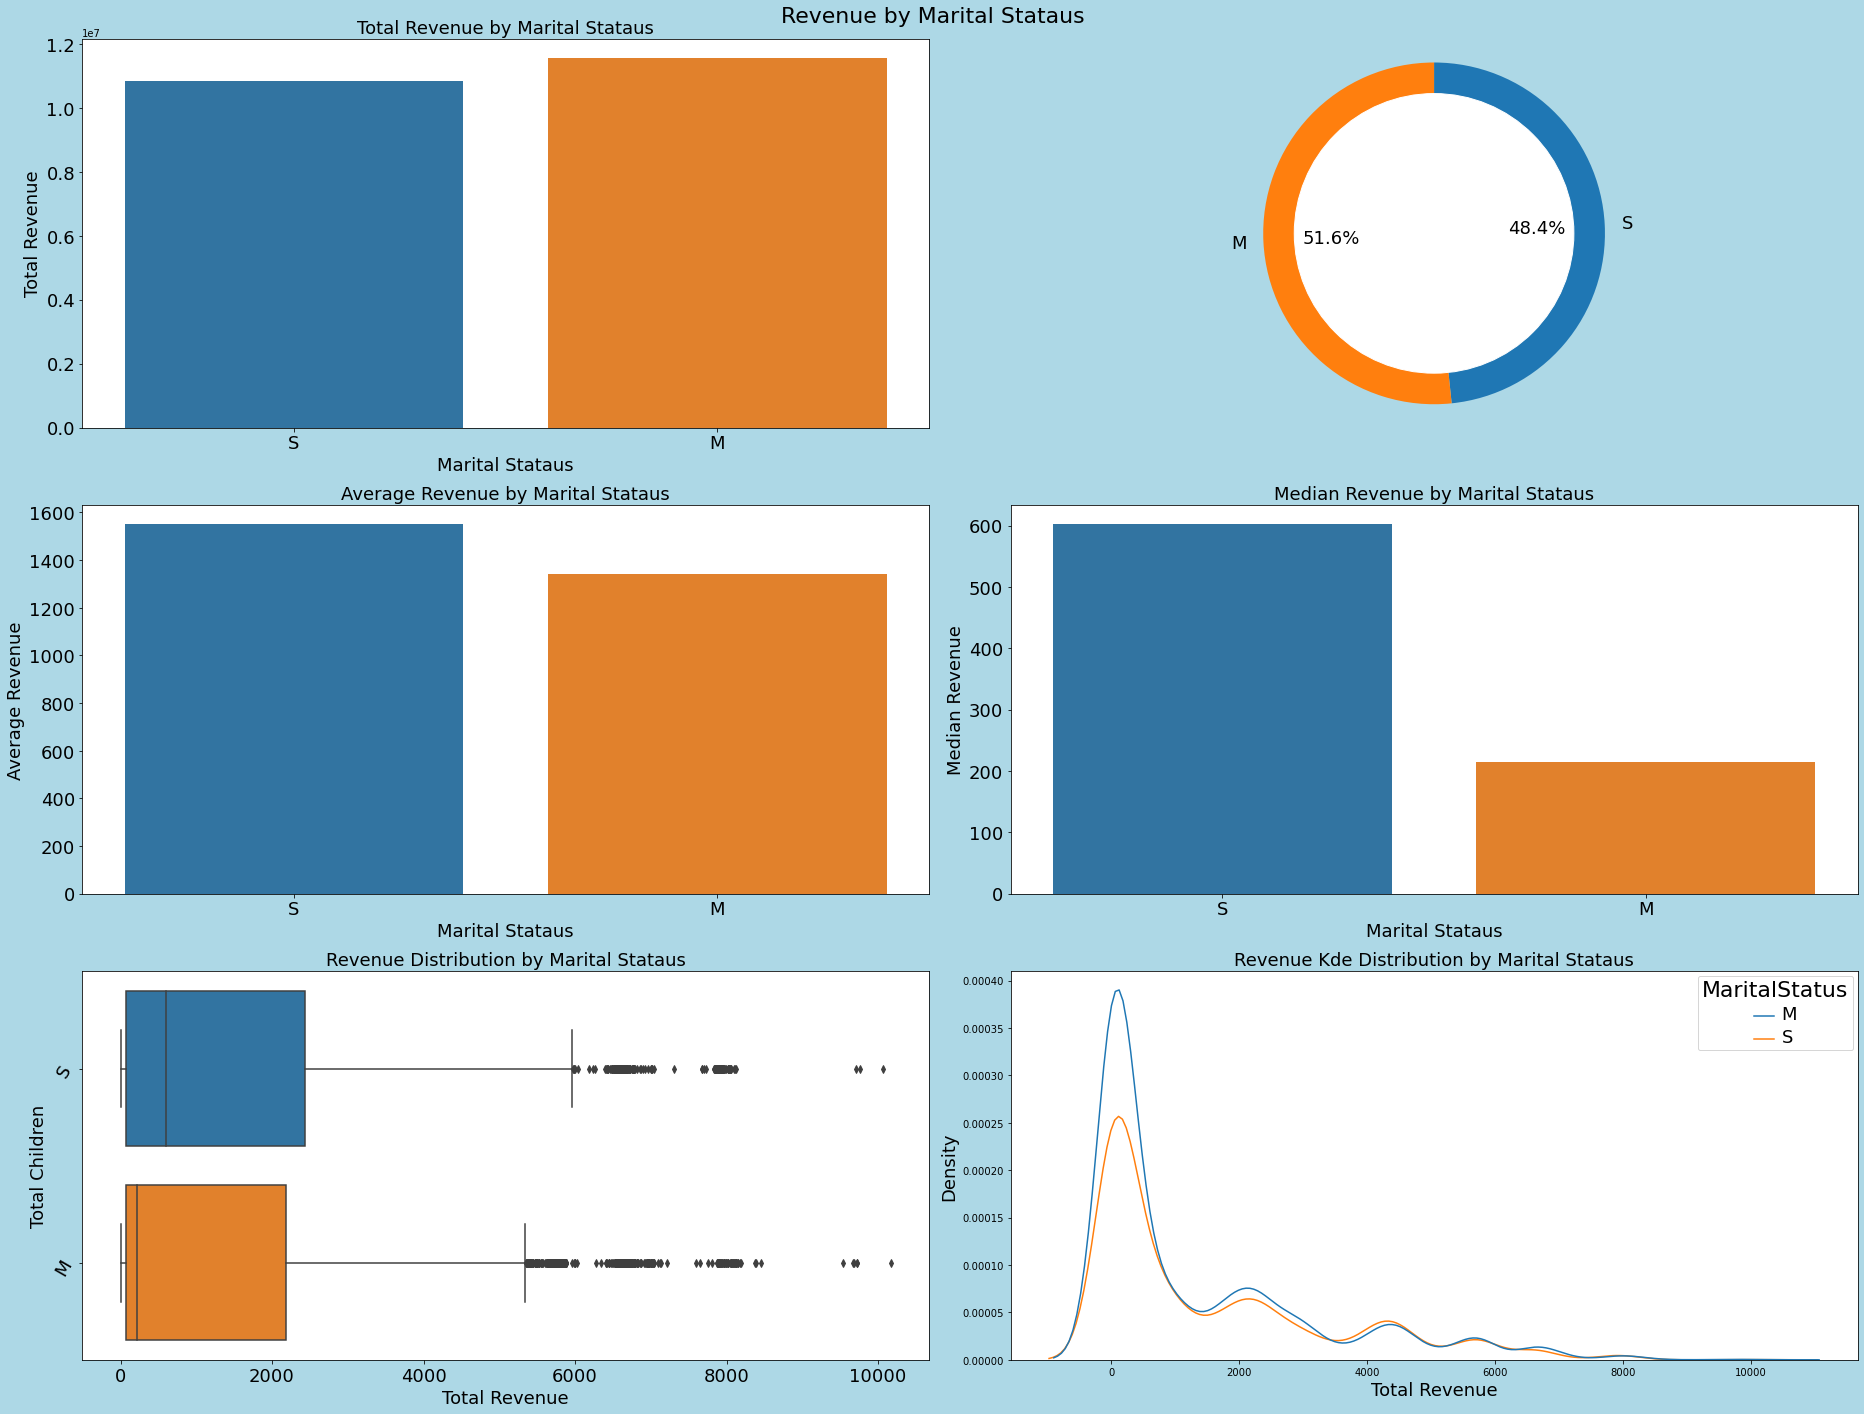

In [38]:
make_rev_vis(rev_by_maritalStatus,customer_maritalStatus_rev,'Marital Stataus','MaritalStatus')

Revenue vs. MaritalStatus Significance:

On average, do signle customers spend more than married customers?

In [39]:
make_stats_test(customer_maritalStatus_rev,rev_by_maritalStatus,'MaritalStatus')

Statistics: 6.954412781191716
P_value 3.68970808448963e-12
There is a significant evidence that single customers spend more than married customers on average


__Inference__\
Although the majority of the customers are married and they generate a larger percentage of the total revenue, single customers spend more on average.

In [40]:
del (customer_maritalStatus_rev,
maritalStatus_count,
rev_by_maritalStatus
 )

### Homeownership Analysis

In [41]:
customer_homeowner_rev = make_customer_category_rev_df(customer_analysis,'HomeOwner')
customer_homeowner_rev.head()

,CustomerKey,HomeOwner,TotalRevenue
1,11000,Y,4656.39
2,11001,N,2821.21
5,11002,Y,4466.81
6,11003,N,4532.99
9,11004,Y,4568.08


__Homeownership Demographic__

Customers by Homewonership Count

In [42]:
homeowner_count = make_customer_count(customer_homeowner_rev, 'HomeOwner')
homeowner_count

,CustomersCount
HomeOwner,
Y,10593
N,5006


Customers by Homewonership Count Visualization

           CustomersCount
HomeOwner                
Y                   10593
N                    5006


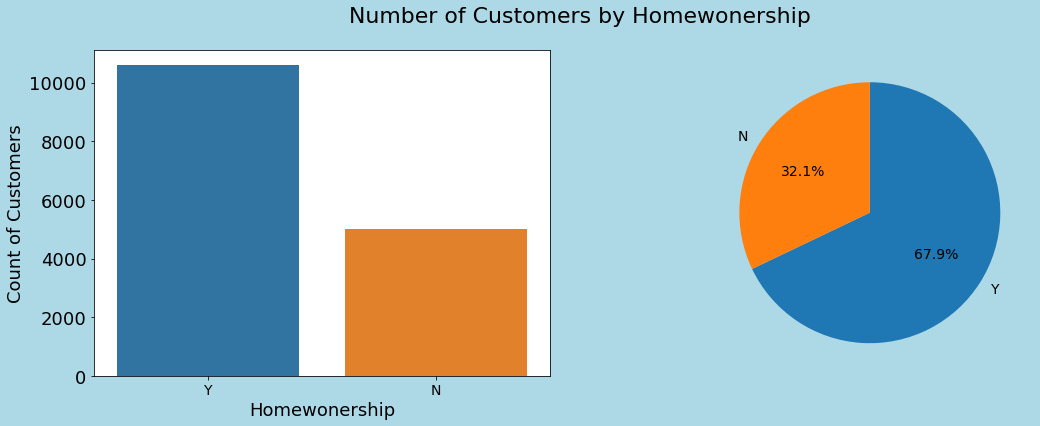

In [43]:
make_count_vis(homeowner_count,'Homewonership')

__Revenue By Homeownership__

Revenue by Homeownership Basic Statistics

In [44]:
make_basic_stats(customer_homeowner_rev,'HomeOwner')

,TotalRevenue
count,10593.000000
mean,1458.753931
std,1885.414594
min,2.290000
25%,73.590000
50%,557.970000
75%,2287.190000
max,9761.600000
,TotalRevenue
count,5006.000000


Total, Average and Median Revenue by Homeownership

In [45]:
rev_by_homeowner = make_agg_rev(customer_homeowner_rev,'HomeOwner')
rev_by_homeowner

,TotalRevenue,AverageRevenue,MedianRevenue
HomeOwner,,,
Y,15452580.39,1458.753931,557.97
N,6956581.49,1389.648720,539.99


In [46]:
home_ownership_list = ['All','Y',"N"]

Revenue by Homeownership Visualization

           TotalRevenue  AverageRevenue  MedianRevenue
HomeOwner                                             
Y           15452580.39     1458.753931         557.97
N            6956581.49     1389.648720         539.99


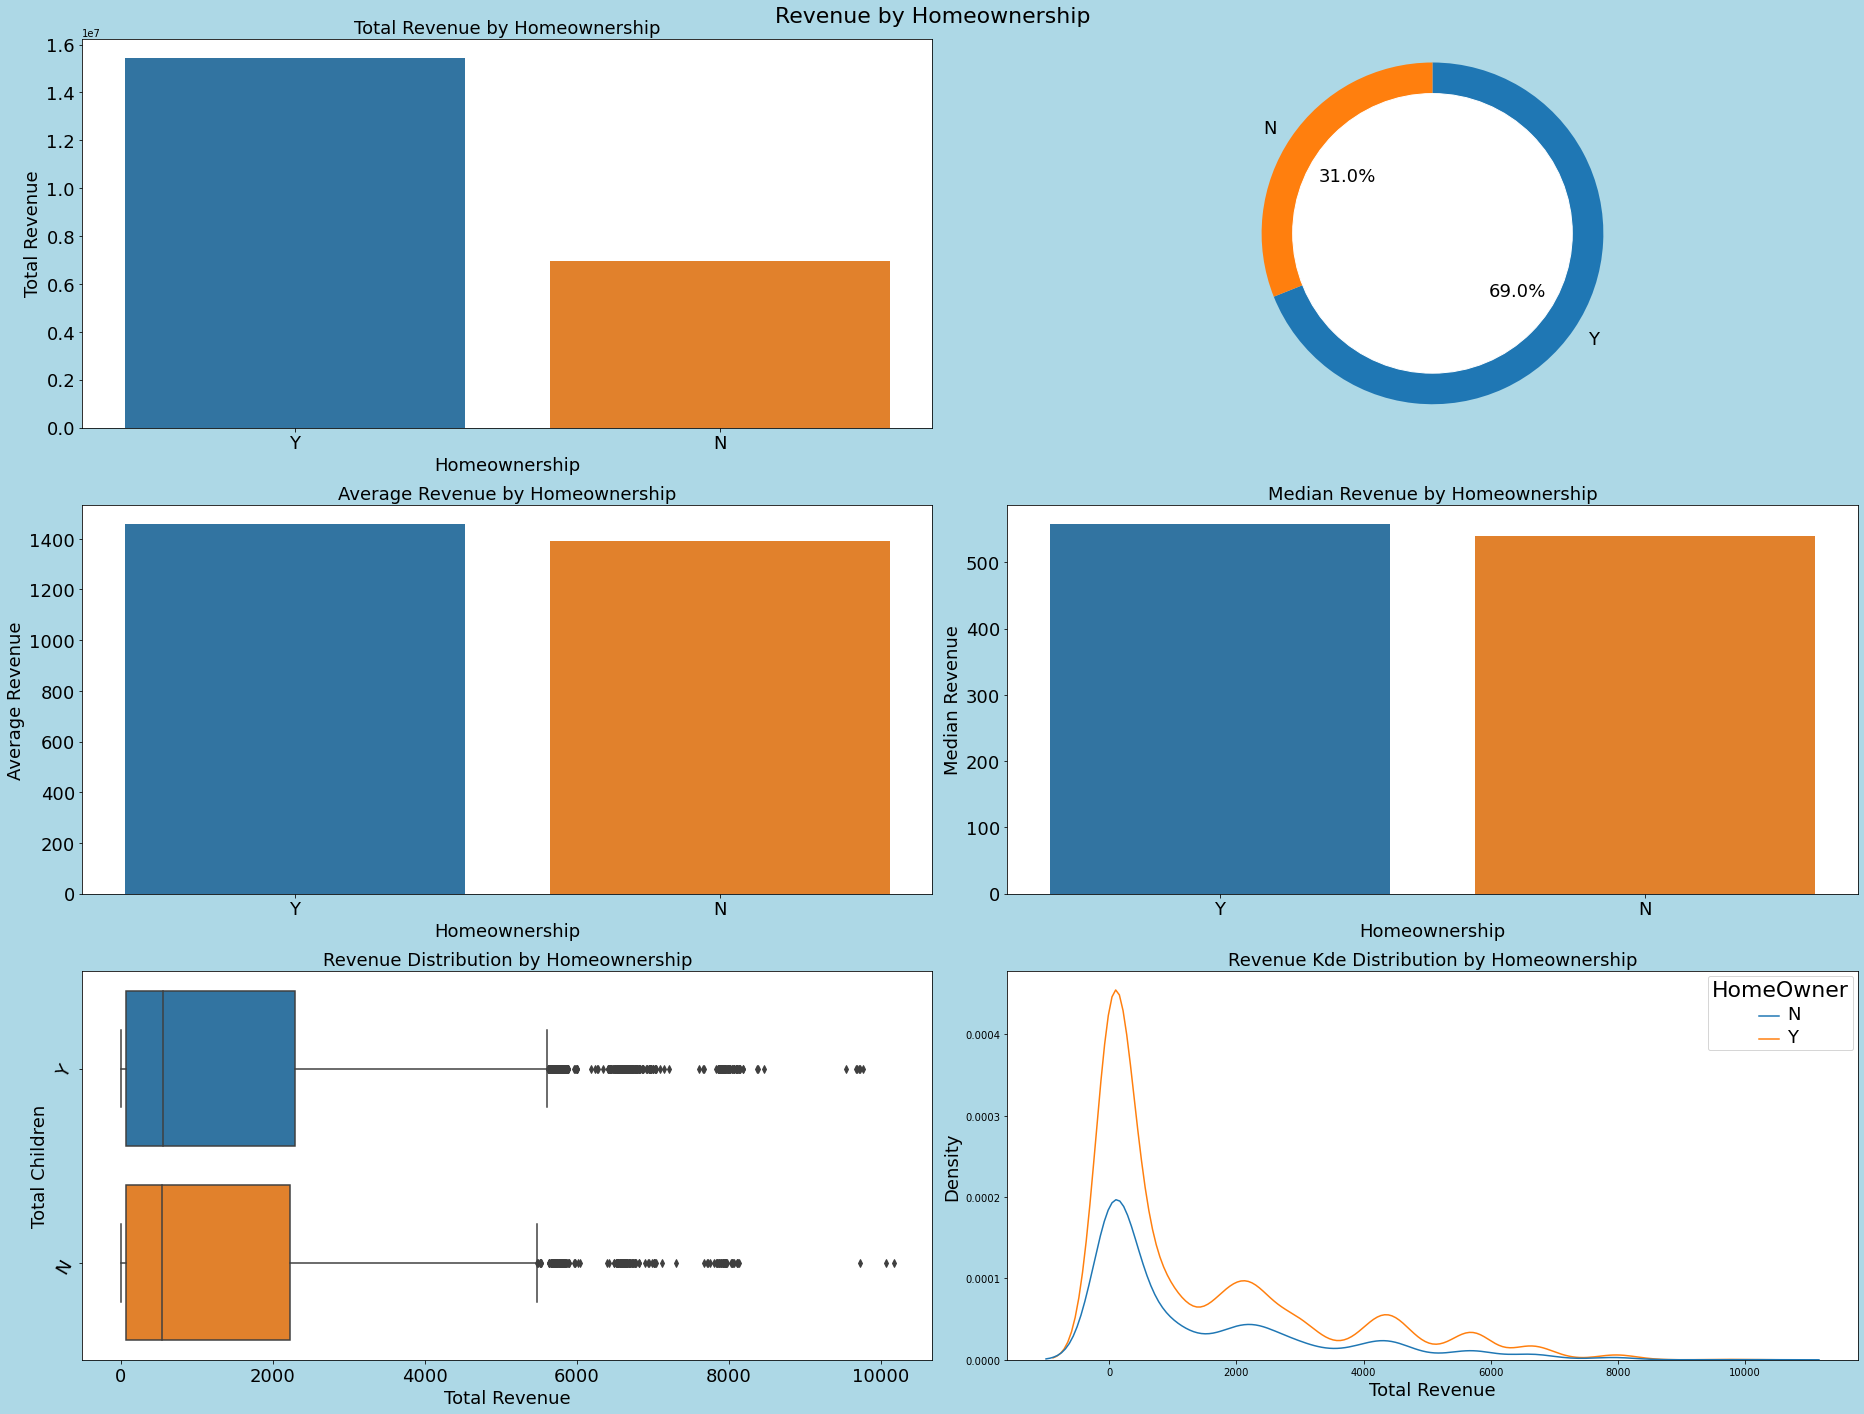

In [47]:
make_rev_vis(rev_by_homeowner, customer_homeowner_rev,'Homeownership','HomeOwner')

Revenue vs. Homeownership Significance:

On average, do the homeowner customers spend more than the non homeonwer customers?

In [48]:
make_stats_test(customer_homeowner_rev,rev_by_homeowner,'HomeOwner')

Statistics: 2.183584266616243
P_value 0.029015726358424778
There is a significant evidence that homeowner customers spend more than non homeowner customers on average


__Inference__\
Homeowner customers comprise the majority of the customers, contribute more to total revenue, and spend more on average than non-homeowner customers.

In [49]:
del(customer_homeowner_rev,
homeowner_count,
rev_by_homeowner
)
gc.collect()

17044

### Education Level Analysis

In [50]:
customer_eduLevel_rev = make_customer_category_rev_df(customer_analysis,'EducationLevel')
customer_eduLevel_rev.head()

,CustomerKey,EducationLevel,TotalRevenue
0,11000,Bachelors,4656.39
5,11001,Bachelors,2821.21
10,11002,Bachelors,4466.81
15,11003,Bachelors,4532.99
20,11004,Bachelors,4568.08


__Education Level Demographic__

Customers by Education Level Count

In [51]:
eduLevel_count = make_customer_count(customer_eduLevel_rev,'EducationLevel')
eduLevel_count

,CustomersCount
EducationLevel,
Bachelors,4757
Partial College,4175
Graduate Degree,2831
High School,2602
Partial High School,1234


Customers by Education Level Count Visualization

                     CustomersCount
EducationLevel                     
Bachelors                      4757
Partial College                4175
Graduate Degree                2831
High School                    2602
Partial High School            1234


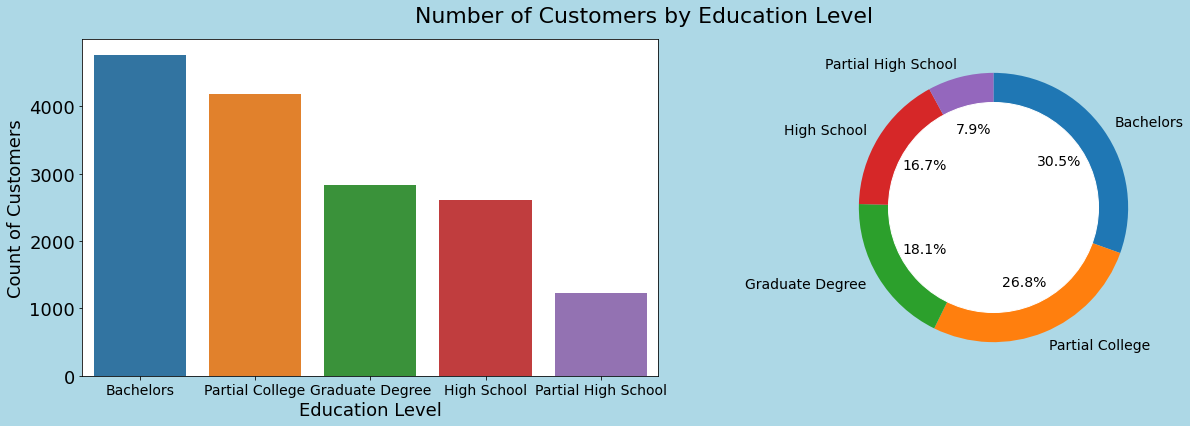

In [52]:
make_count_vis(eduLevel_count,'Education Level')

__Revenue By Education Level__

Revenue By Education Level basic Statistics

In [53]:
make_basic_stats(customer_eduLevel_rev,'EducationLevel')

,TotalRevenue
count,4757.000000
mean,1644.607383
std,1963.107399
min,2.290000
25%,87.970000
50%,624.040000
75%,2513.630000
max,10065.010000
,TotalRevenue
count,4175.000000


Total, Mean and Median Revenue by Education Level

In [54]:
rev_by_eduLevel = make_agg_rev(customer_eduLevel_rev,'EducationLevel')
rev_by_eduLevel

,TotalRevenue,AverageRevenue,MedianRevenue
EducationLevel,,,
Bachelors,7823397.32,1644.607383,624.040
Graduate Degree,4345103.63,1534.829965,602.940
Partial College,5770490.03,1382.153301,573.630
High School,3264711.68,1254.693190,150.035
Partial High School,1205459.22,976.871329,98.600


Revenue by Education Level Visualiztion

                     TotalRevenue  AverageRevenue  MedianRevenue
EducationLevel                                                  
Bachelors              7823397.32     1644.607383        624.040
Graduate Degree        4345103.63     1534.829965        602.940
Partial College        5770490.03     1382.153301        573.630
High School            3264711.68     1254.693190        150.035
Partial High School    1205459.22      976.871329         98.600


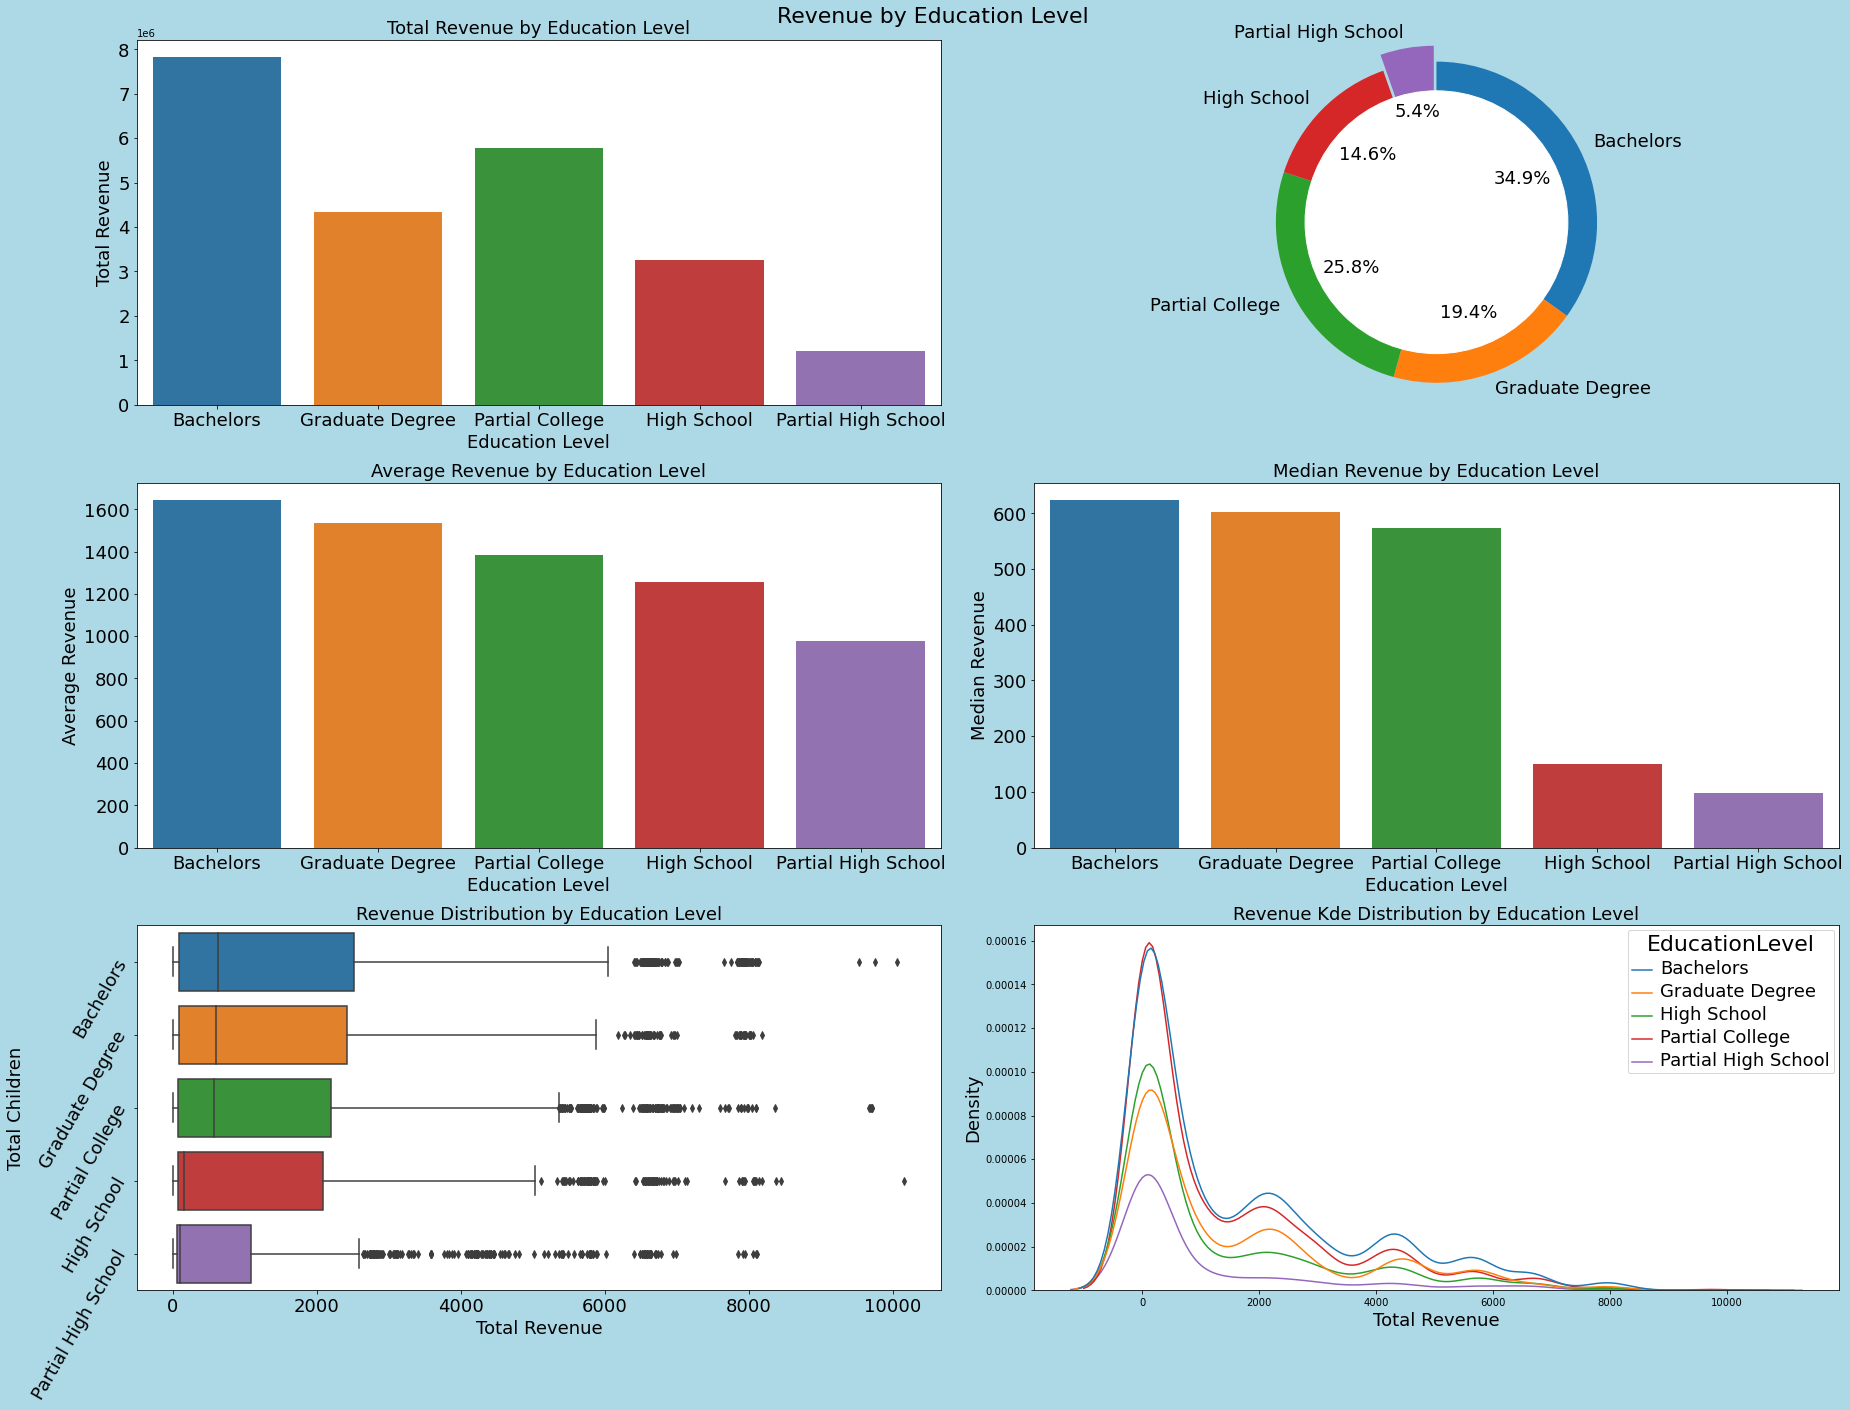

In [55]:
make_rev_vis(rev_by_eduLevel, customer_eduLevel_rev,'Education Level','EducationLevel')

Revenue vs. Education Level Significance :

Assuming that the data represents a sample of the customers population,is there a significant difference between customers with a bachelor's degree and those with graduate degree in term of the average total revenue (on average, do the customers with bachelor's degree spend more than those with graduate degree)?

In [56]:
make_stats_test(customer_eduLevel_rev,rev_by_eduLevel,'EducationLevel')

Statistics: 2.4048578086041896
P_value 0.016208339734332118
There is a significant evidence that Bachelors customers spend more than Graduate Degree customers on average


__Inference__\
Although customers with Bachelors' degree come as the second largest customer segement, contribute more than any other segement in the total revenue, and spend more on average than those of a Graduate degree.

In [57]:
del(customer_eduLevel_rev,
eduLevel_count,
rev_by_eduLevel)
gc.collect()

22708

### Occupation Analysis

In [58]:
customer_occupation_rev = make_customer_category_rev_df(customer_analysis,'Occupation')
customer_occupation_rev.head()

,CustomerKey,Occupation,TotalRevenue
3,11000,Professional,4656.39
8,11001,Professional,2821.21
13,11002,Professional,4466.81
18,11003,Professional,4532.99
23,11004,Professional,4568.08


__Occupation Demographic Count__

Customers by Occupation Count

In [59]:
occupation_count = make_customer_count(customer_occupation_rev,'Occupation')
occupation_count

,CustomersCount
Occupation,
Professional,4973
Skilled Manual,4112
Management,2803
Clerical,2199
Manual,1512


Customers by Occupation Count Visualiztion

                CustomersCount
Occupation                    
Professional              4973
Skilled Manual            4112
Management                2803
Clerical                  2199
Manual                    1512


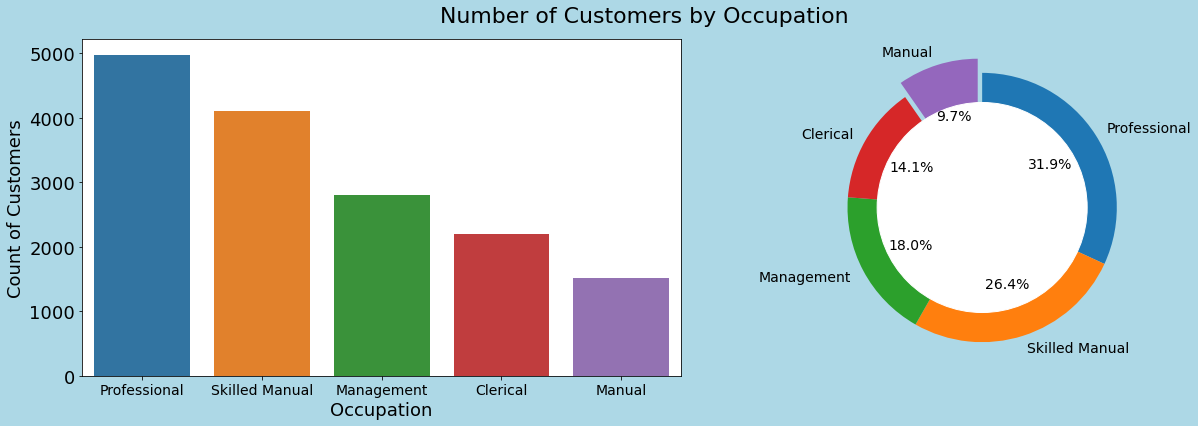

In [60]:
make_count_vis(occupation_count,'Occupation')

__Revenue by Occupation__

Revenue by Occupation Basic Statistics

In [61]:
make_basic_stats(customer_occupation_rev,'Occupation')

,TotalRevenue
count,4973.000000
mean,1601.679867
std,2050.745544
min,3.990000
25%,78.620000
50%,567.950000
75%,2419.060000
max,10165.920000
,TotalRevenue
count,4112.000000


Total, Average and Median Revneu by Occupation

In [62]:
rev_by_occupation = make_agg_rev(customer_occupation_rev,'Occupation')
rev_by_occupation

,TotalRevenue,AverageRevenue,MedianRevenue
Occupation,,,
Professional,7965153.98,1601.679867,567.950
Management,4473044.51,1595.806104,262.000
Clerical,3092905.38,1406.505402,616.950
Skilled Manual,5101762.73,1240.701053,539.990
Manual,1776295.28,1174.798466,197.525


Revenue by Occupation Visualization 

                TotalRevenue  AverageRevenue  MedianRevenue
Occupation                                                 
Professional      7965153.98     1601.679867        567.950
Management        4473044.51     1595.806104        262.000
Clerical          3092905.38     1406.505402        616.950
Skilled Manual    5101762.73     1240.701053        539.990
Manual            1776295.28     1174.798466        197.525


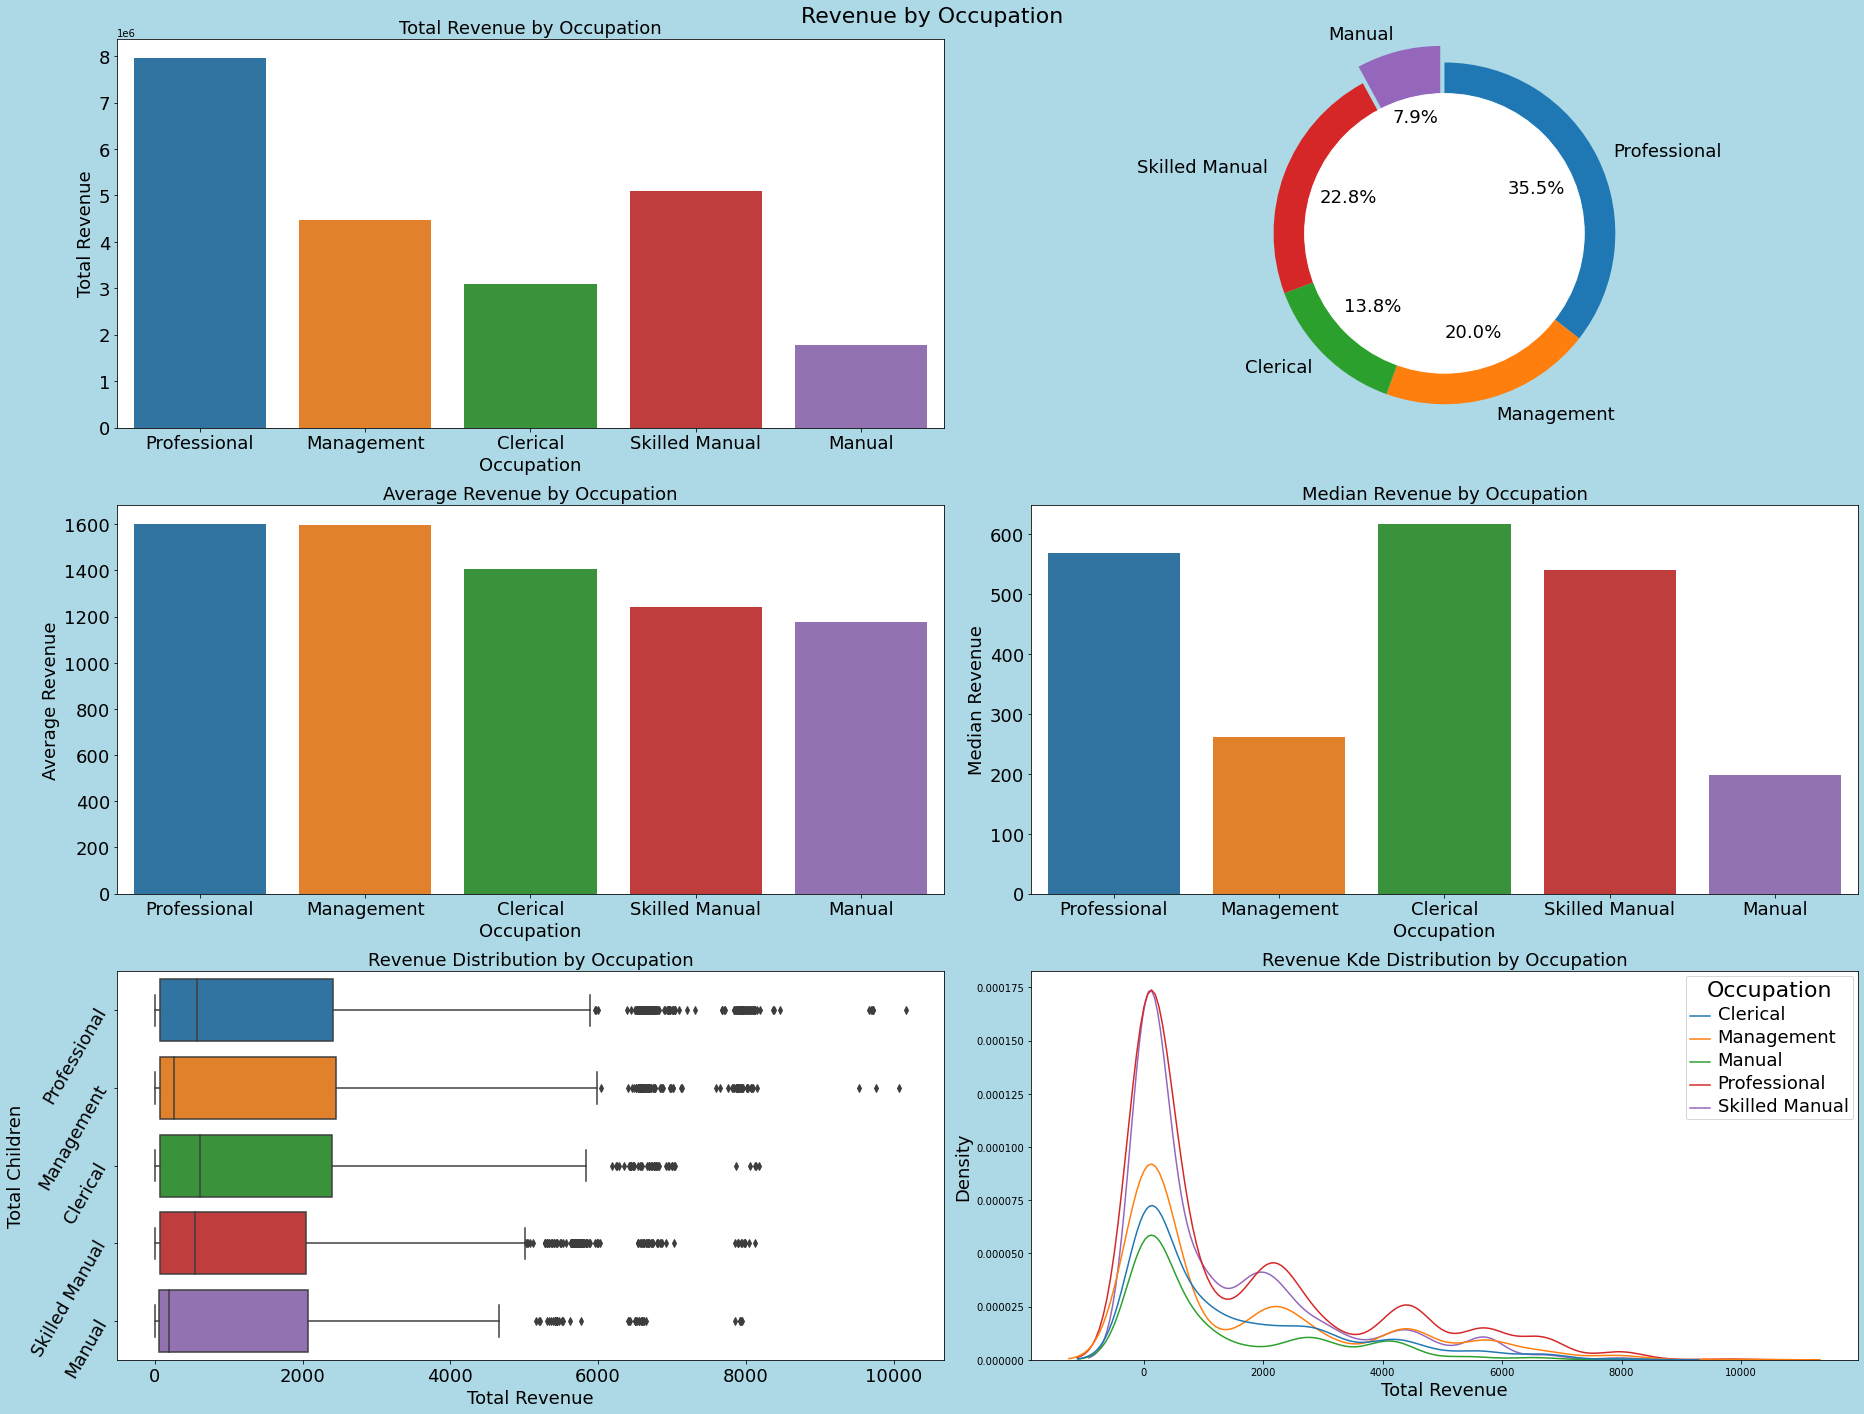

In [63]:
make_rev_vis(rev_by_occupation,customer_occupation_rev,'Occupation','Occupation')

Occupation vs. Revenue Significance:

Is there a significant difference between customers with a customers working as Professionals ans thos working in Management positions in term of the average total revenue (on average, do the professionals spend more than those with managerial positions)?

In [64]:
make_stats_test(customer_occupation_rev,rev_by_occupation,'Occupation')

Statistics: 0.12127951018795591
P_value 0.9034727831762981
There is no significant evidence that Professional customers spend more than Management customers on average


__Inference__\
Customers working as Professionals comprise the largest occupation segement of the customers and contribute more than any other segment in the total revenue. However, in term of the average revenue per customer, there is no sinificant difference between customers with professional job titles and those with managerial job titles.

In [65]:
del (customer_occupation_rev,
occupation_count,
rev_by_occupation)
gc.collect()

22631

### Annual Income Level Analysis

In [66]:
customer_incomeLevel_rev = make_customer_category_rev_df(customer_analysis,'IncomeLevel')
customer_incomeLevel_rev.head()

,CustomerKey,IncomeLevel,TotalRevenue
0,11000,High Income Level,4656.39
5,11001,Medium Income Level,2821.21
8,11002,Medium Income Level,4466.81
11,11003,Medium Income Level,4532.99
14,11004,Medium Income Level,4568.08


__Annual Income Level Demographic__

Customers by Annual Income Level Count

In [67]:
incomeLevel_count = make_customer_count(customer_incomeLevel_rev,'IncomeLevel')
incomeLevel_count

,CustomersCount
IncomeLevel,
Medium Income Level,9223
Low Income Level,3691
High Income Level,2685


Customers by Annual Income Level Count Visualization

                     CustomersCount
IncomeLevel                        
Medium Income Level            9223
Low Income Level               3691
High Income Level              2685


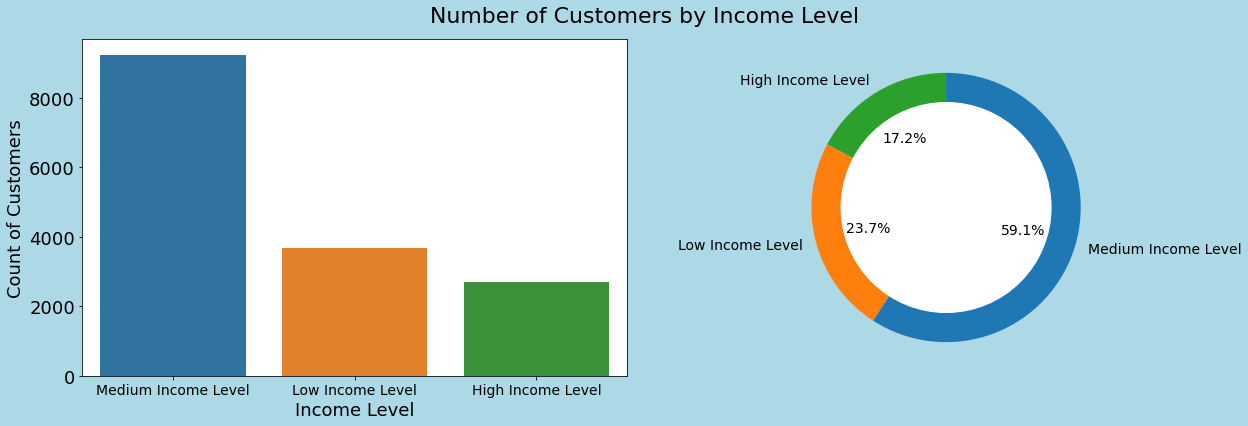

In [68]:
make_count_vis(incomeLevel_count,'Income Level')

__Revenue By Income Level__

Revenue by Income Level Basic Statistics

In [69]:
make_basic_stats(customer_incomeLevel_rev,'IncomeLevel')

,TotalRevenue
count,9223.000000
mean,1384.062564
std,1772.241188
min,2.290000
25%,77.600000
50%,567.950000
75%,2165.360000
max,9716.990000
,TotalRevenue
count,3691.000000


Total, Average and Median Revenue by Income Level

In [70]:
rev_by_incomeLevel = make_agg_rev(customer_incomeLevel_rev,'IncomeLevel')
rev_by_incomeLevel

,TotalRevenue,AverageRevenue,MedianRevenue
IncomeLevel,,,
High Income Level,5523881.91,2057.311698,751.26
Medium Income Level,12765209.03,1384.062564,567.95
Low Income Level,4120070.94,1116.247884,178.91


Revenue by Income Level Visualization

                     TotalRevenue  AverageRevenue  MedianRevenue
IncomeLevel                                                     
High Income Level      5523881.91     2057.311698         751.26
Medium Income Level   12765209.03     1384.062564         567.95
Low Income Level       4120070.94     1116.247884         178.91


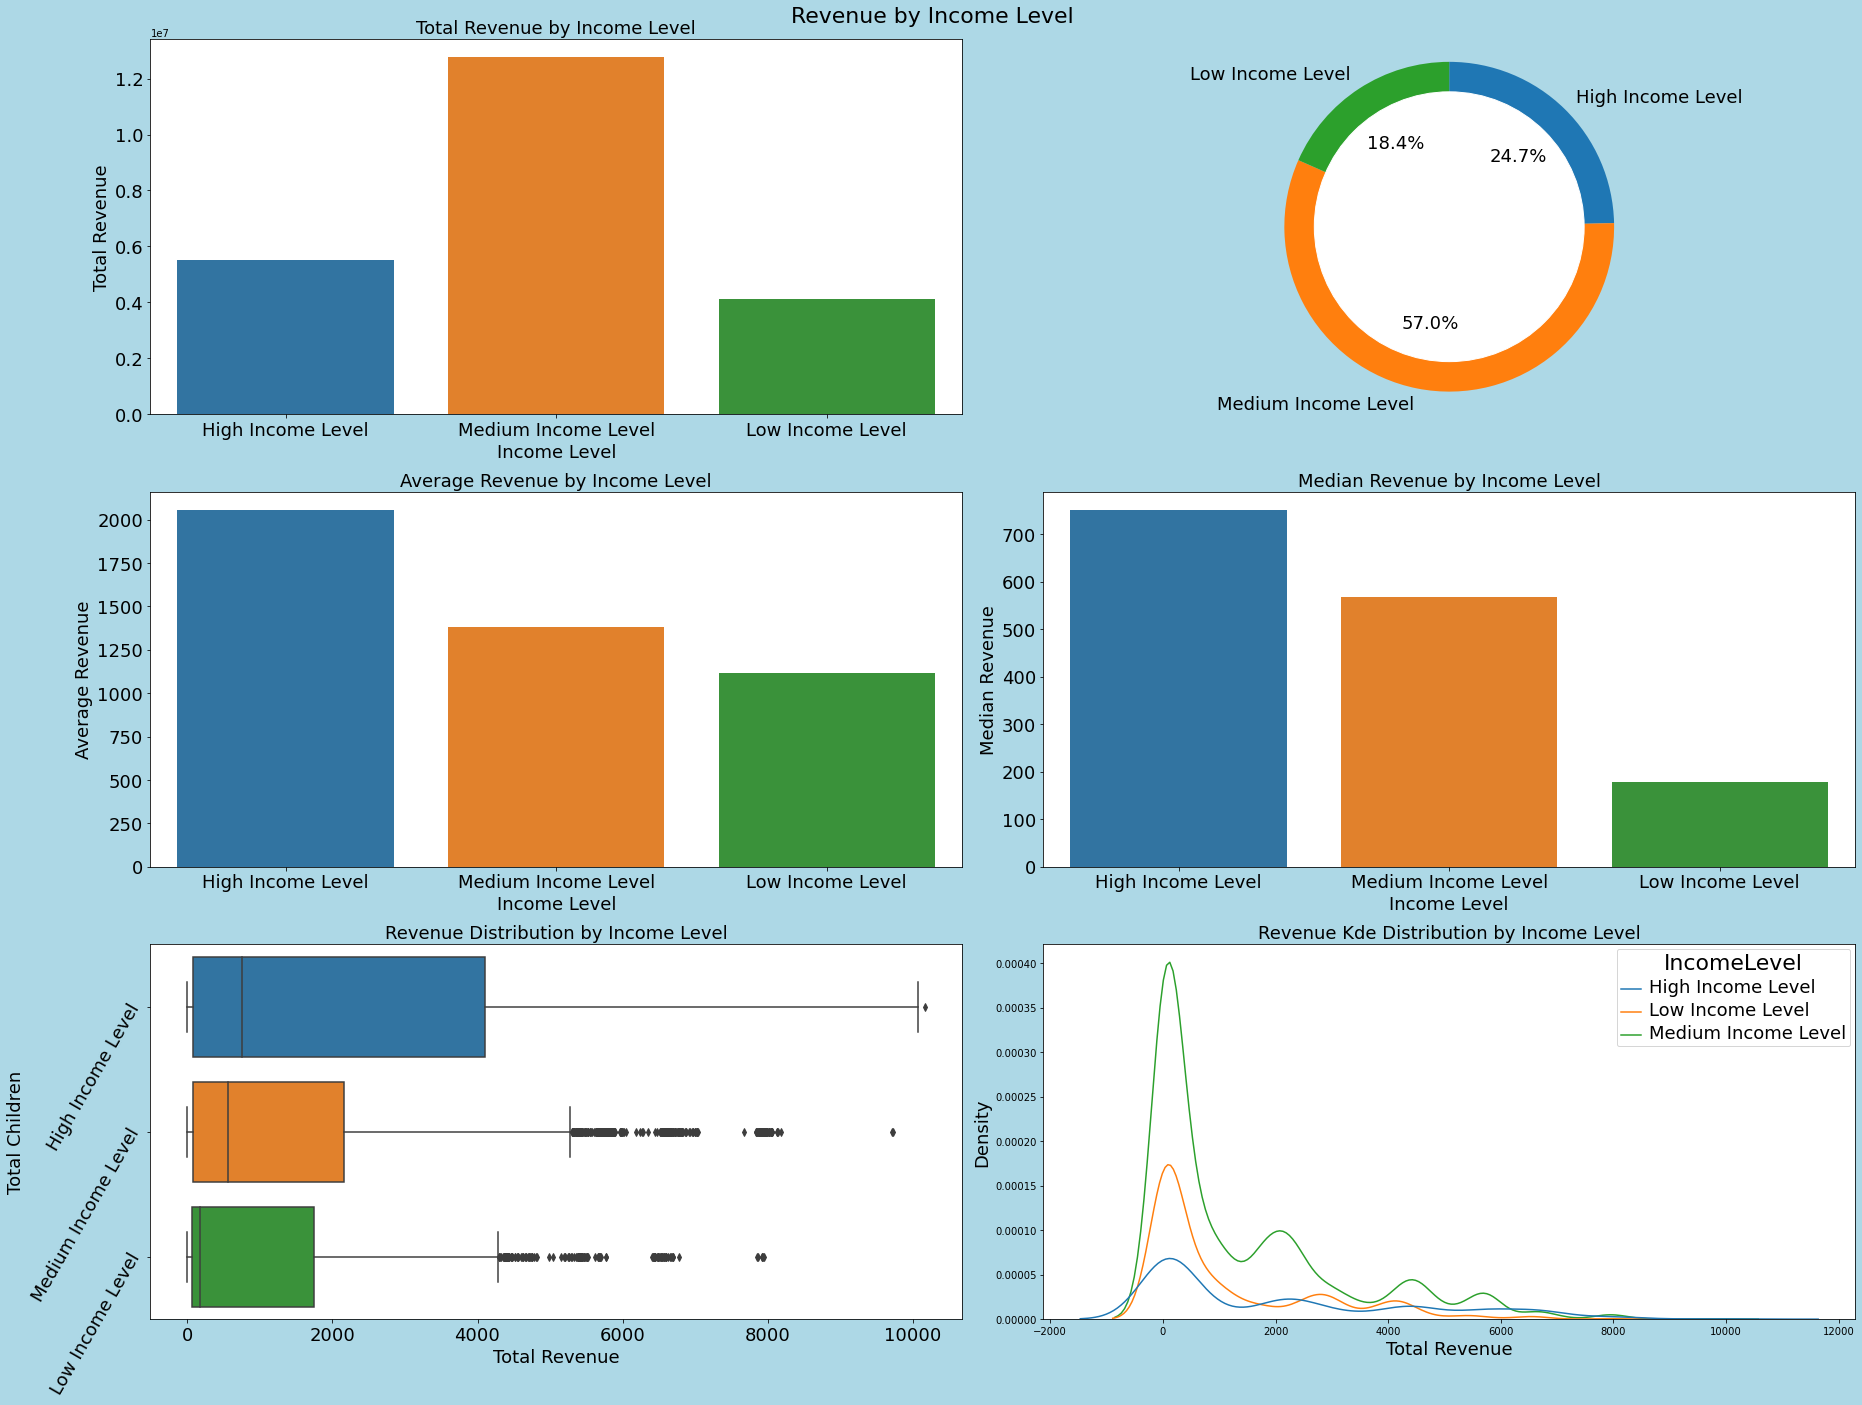

In [71]:
make_rev_vis(rev_by_incomeLevel,customer_incomeLevel_rev,'Income Level','IncomeLevel')

Revenue vs. Income Level Significance\
Is there a significant evidence that customers with 'High Income Level' spend more on average than those with 'Medium Income Level'?

In [72]:
make_stats_test(customer_incomeLevel_rev,rev_by_incomeLevel,'IncomeLevel')

Statistics: 13.602910279705199
P_value 3.948552437031375e-41
There is a significant evidence that High Income Level customers spend more than Medium Income Level customers on average


__Inference__\
Customers with a Medium Income Level comprise the largest percentage of total customers,contribute more in the total revenue. However, customers with a High income Level spend more on average.

In [73]:
del (customer_incomeLevel_rev,
incomeLevel_count,
rev_by_incomeLevel)
gc.collect()

24612

### Age Group Analysis

For the analysis of demographic, I'll use 'AgeGroup_BasedOnPresentDate' which is the last date in the dataset. However, for the analysis of Revenue vs. Age Group, I'll use 'AgeGroup_BasedOnOrderDate'.

In [74]:
customer_ageGroup1_rev = make_customer_category_rev_df(customer_analysis,'AgeGroup_BasedOnPresentDate')
customer_ageGroup1_rev.head()

,CustomerKey,AgeGroup,TotalRevenue
1,11000,40-59,4656.39
6,11001,40-59,2821.21
11,11002,40-59,4466.81
16,11003,40-59,4532.99
21,11004,40-59,4568.08


__Age Group Demographic__

Customers by Age Group Count

In [75]:
ageGroup_count = make_customer_count(customer_ageGroup1_rev,'AgeGroup')
ageGroup_count

,CustomersCount
AgeGroup,
40-59,9520
60-79,4842
20-39,824
80-99,406


Customers by Age Group Count Visualization

          CustomersCount
AgeGroup                
40-59               9520
60-79               4842
20-39                824
80-99                406


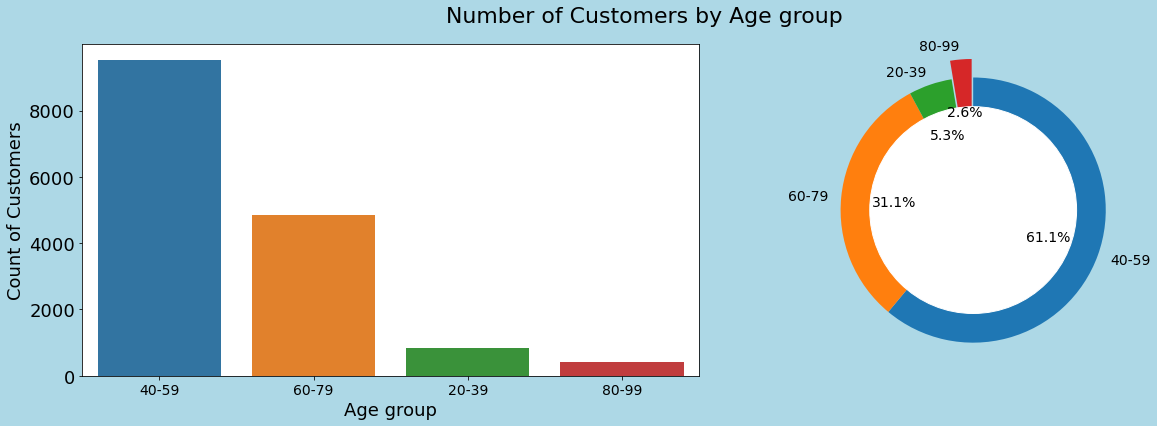

In [76]:
make_count_vis(ageGroup_count,'Age group')

__Revenue by Age Group__

In [77]:
customer_ageGroup2_rev = make_customer_category_rev_df(customer_analysis,'AgeGroup_BasedOnOrderDate')
customer_ageGroup2_rev.head()

,CustomerKey,AgeGroup,TotalRevenue
1,11000,40-59,4656.39
6,11001,40-59,2821.21
11,11002,40-59,4466.81
16,11003,40-59,4532.99
21,11004,40-59,4568.08


Revenue by Age Group Basic Statistics

In [78]:
make_basic_stats(customer_ageGroup2_rev,'AgeGroup')

,TotalRevenue
count,1046.000000
mean,1245.639168
std,1453.316247
min,2.290000
25%,73.480000
50%,588.890000
75%,2181.560000
max,6590.510000
,TotalRevenue
count,9741.000000


Total, Average and Median Revenue by Occupation

In [79]:
rev_by_ageGroup = make_agg_rev(customer_ageGroup2_rev,'AgeGroup')
rev_by_ageGroup

,TotalRevenue,AverageRevenue,MedianRevenue
AgeGroup,,,
40-59,14992115.90,1539.073596,604.460
20-39,1302938.57,1245.639168,588.890
60-79,5832557.46,1230.497354,163.960
80-99,280867.19,780.186639,87.775


Revenue by Age Group Visualization

          TotalRevenue  AverageRevenue  MedianRevenue
AgeGroup                                             
40-59      14992115.90     1539.073596        604.460
20-39       1302938.57     1245.639168        588.890
60-79       5832557.46     1230.497354        163.960
80-99        280867.19      780.186639         87.775


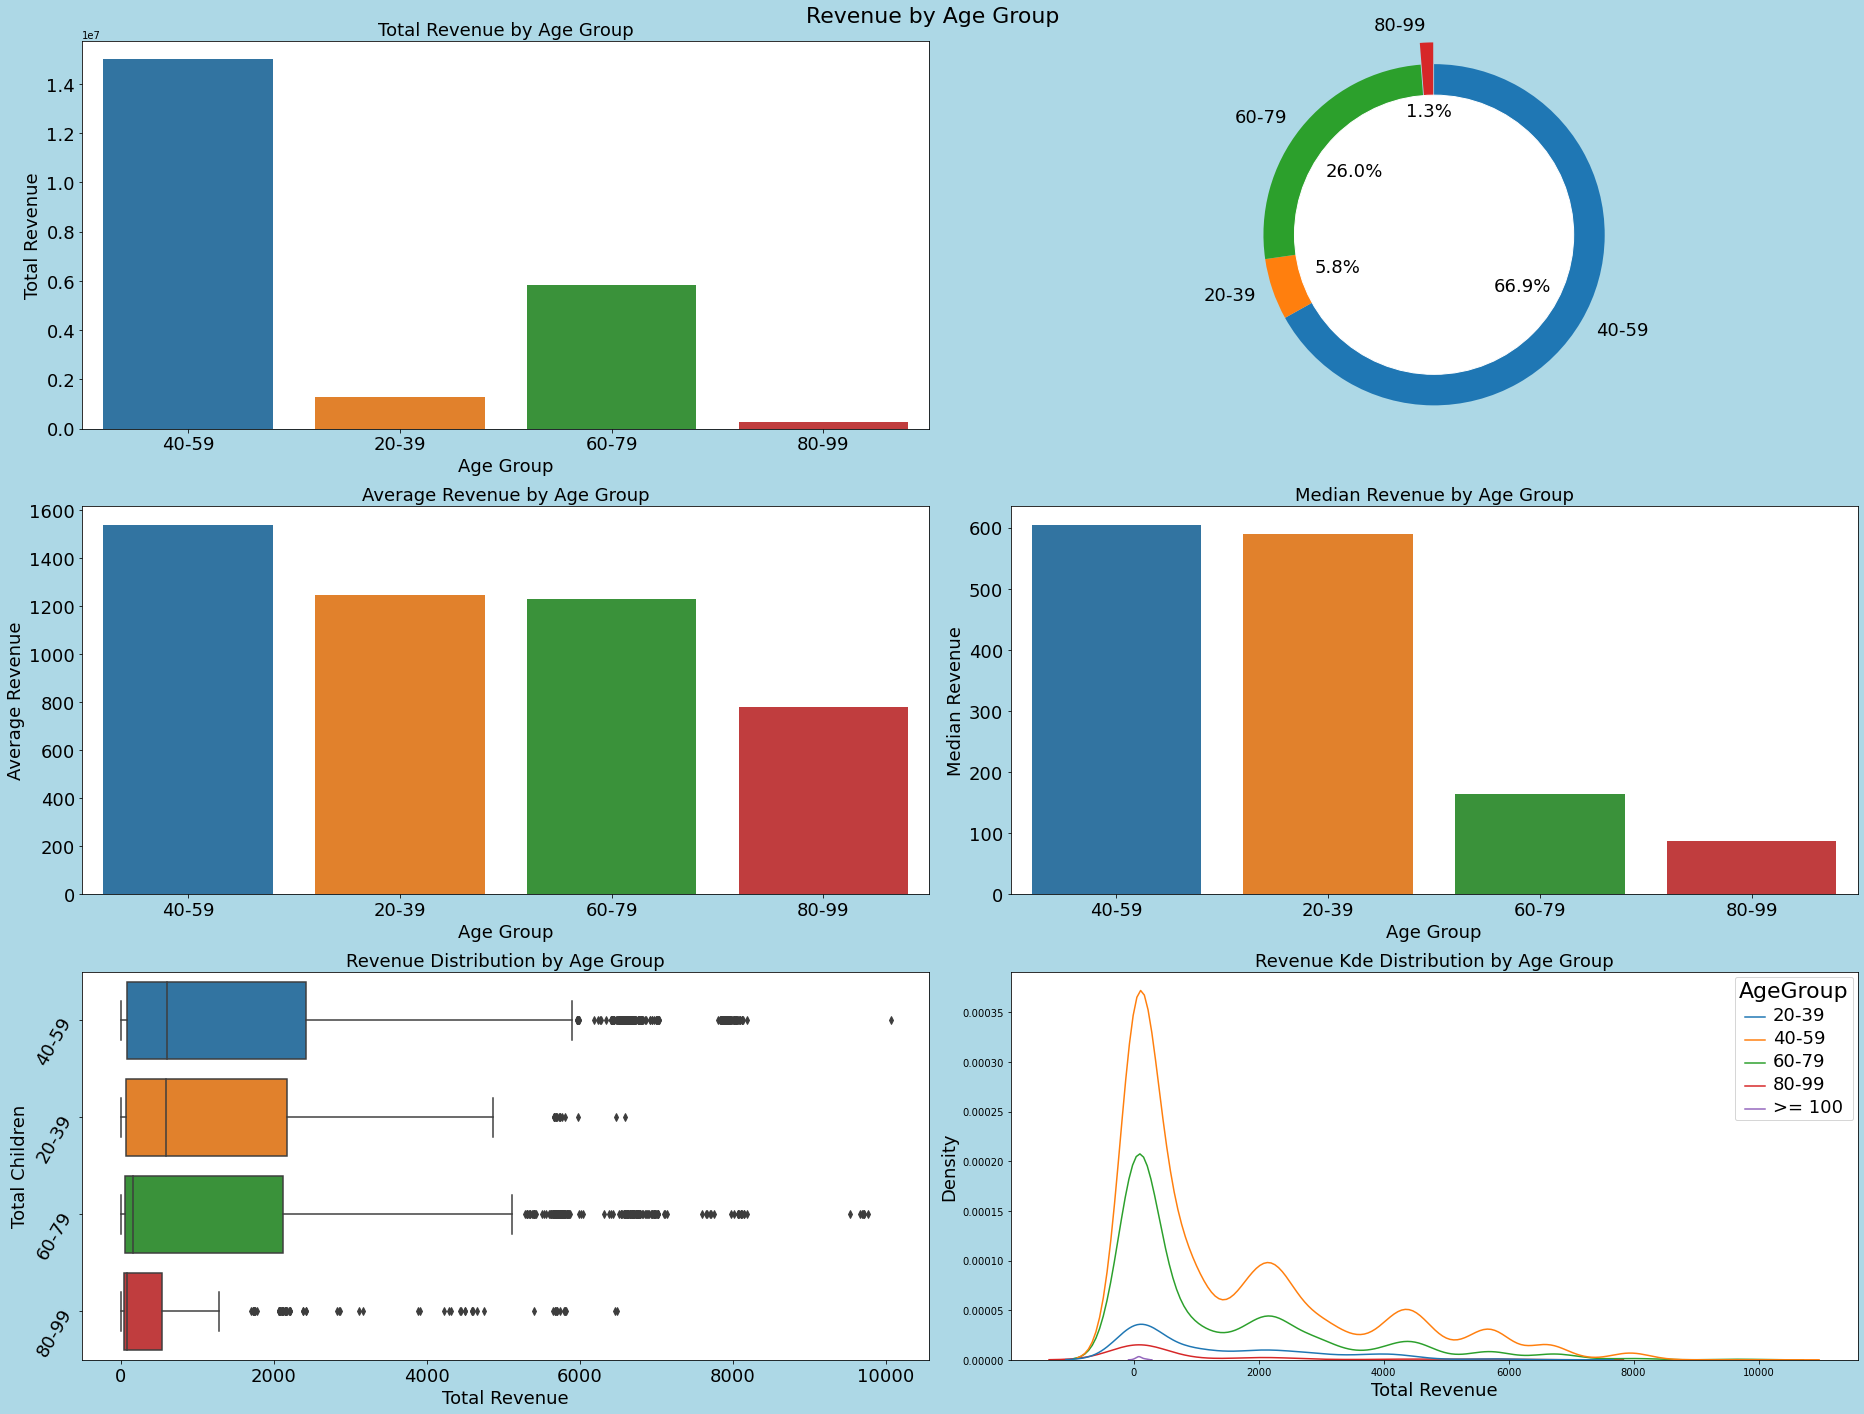

In [80]:
make_rev_vis(rev_by_ageGroup,customer_ageGroup2_rev,'Age Group','AgeGroup')

Revenue vs. Age Group Significance

Is there a significance evidence that customers between 40 to 59 yo spend more on average than those between 20 and 39?

In [81]:
make_stats_test(customer_ageGroup2_rev,rev_by_ageGroup,'AgeGroup')

Statistics: 6.008158237951359
P_value 2.3679929234406445e-09
There is a significant evidence that 40-59 customers spend more than 20-39 customers on average


__Inference__\
Customer of the age-group '40-59' comprise the largest age group, contribute larger than any other age-group to the total revenue, and have the largest average revenue per customer.

In [82]:
del (customer_ageGroup1_rev,
ageGroup_count,
customer_ageGroup2_rev,
rev_by_ageGroup)
gc.collect()

21049

### Total Children Analysis

In [83]:
customer_tchildren_rev=make_customer_category_rev_df(customer_analysis,'TotalChildren')
customer_tchildren_rev.head()

,CustomerKey,TotalChildren,TotalRevenue
0,11000,2,4656.39
1,11001,3,2821.21
2,11002,3,4466.81
3,11003,0,4532.99
4,11004,5,4568.08


__Total Children Demographic__

Customers by Total Children Count 

In [84]:
tchildren_count = make_customer_count(customer_tchildren_rev,'TotalChildren')
tchildren_count

,CustomersCount
TotalChildren,
0,4370
2,3170
1,3016
4,1988
3,1891
5,1164


Customers by Total Children Count Visualization

               CustomersCount
TotalChildren                
0                        4370
2                        3170
1                        3016
4                        1988
3                        1891
5                        1164


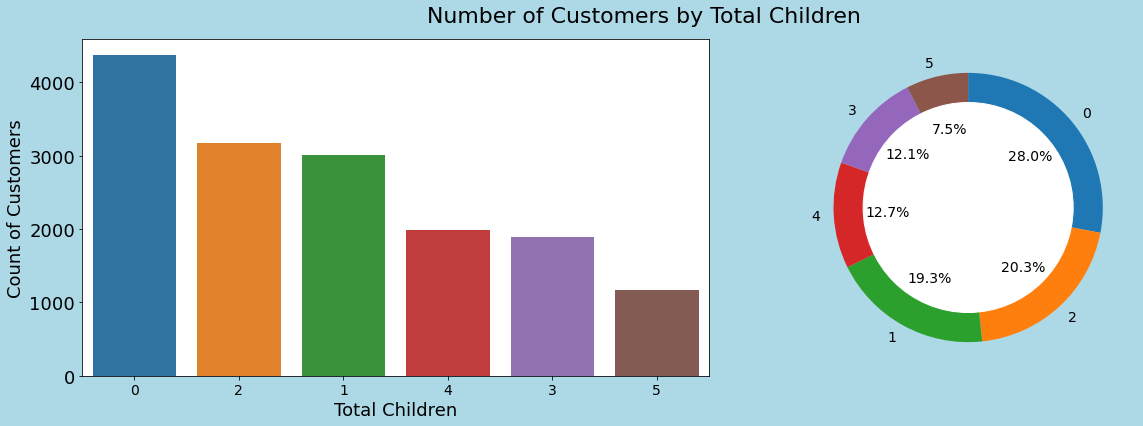

In [85]:
make_count_vis(tchildren_count, 'Total Children')

__Revenue by Total Children__

Revenue by Total Children Basic Statistics

In [86]:
make_basic_stats(customer_tchildren_rev,'TotalChildren')

,TotalRevenue
count,4370.000000
mean,1522.124146
std,1933.632503
min,2.290000
25%,77.600000
50%,574.980000
75%,2417.710000
max,8182.090000
,TotalRevenue
count,3170.000000


Total, Average and Median Revenue by Total Children

In [87]:
rev_by_tchildren = make_agg_rev(customer_tchildren_rev,'TotalChildren')
rev_by_tchildren

,TotalRevenue,AverageRevenue,MedianRevenue
TotalChildren,,,
1,4928062.65,1633.973027,1000.44
0,6651682.52,1522.124146,574.98
2,4624991.23,1458.987770,573.63
3,2626253.19,1388.817129,367.49
4,2337289.64,1175.699014,131.14
5,1240882.65,1066.050387,122.62


Revenue by Total Children Visualization

               TotalRevenue  AverageRevenue  MedianRevenue
TotalChildren                                             
1                4928062.65     1633.973027        1000.44
0                6651682.52     1522.124146         574.98
2                4624991.23     1458.987770         573.63
3                2626253.19     1388.817129         367.49
4                2337289.64     1175.699014         131.14
5                1240882.65     1066.050387         122.62


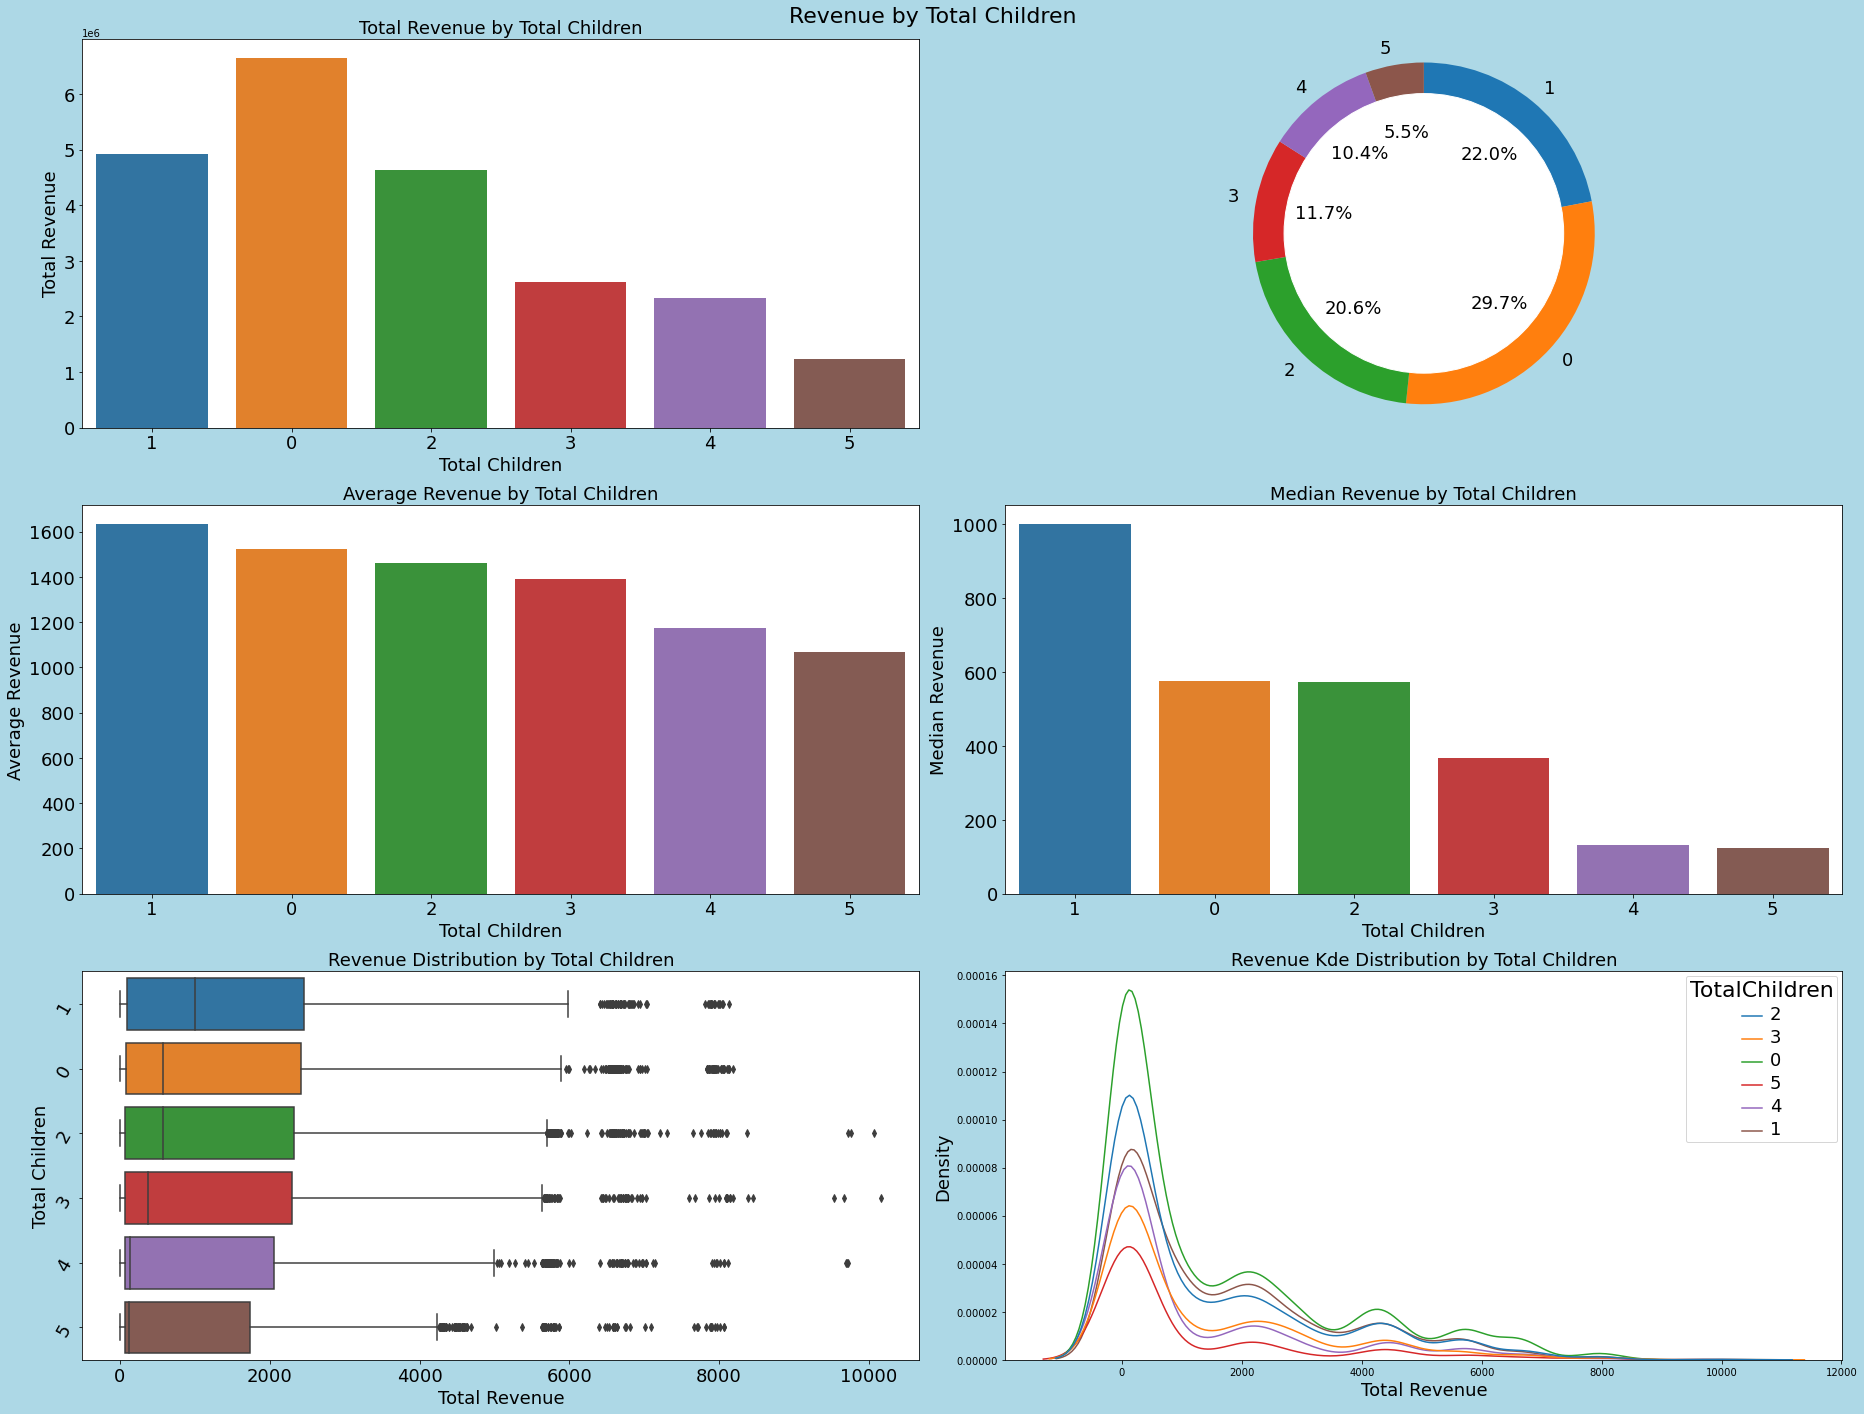

In [88]:
make_rev_vis(rev_by_tchildren,customer_tchildren_rev,'Total Children','TotalChildren')

Revenue vs. Total Children Significance:\
Do customers with 1 child spend more on average than those with 3 children?

In [89]:
make_stats_test(customer_tchildren_rev,rev_by_tchildren,'TotalChildren')

Statistics: 2.5320028932296315
P_value 0.0113638603222521
There is a significant evidence that 1 child customers spend more than 3 children customers on average


__Inference__\
Customers without children comprise the largest segment and contribute the more than any other segment to the total revenue. However, customers with 1 child spend more on average than any other segment.

In [90]:
del (customer_tchildren_rev,
tchildren_count,
rev_by_tchildren)
gc.collect()

30903

### Country Analysis

In [91]:
customer_country_rev = make_customer_category_rev_df(customer_analysis,'Country')
customer_country_rev.head()

,CustomerKey,Country,TotalRevenue
0,11000,Australia,4656.39
5,11001,Australia,2821.21
10,11002,Australia,4466.81
15,11003,Australia,4532.99
20,11004,Australia,4568.08


__Country Demographic__

Customers by Country Count

In [92]:
country_count = make_customer_count(customer_country_rev,'Country')
country_count

,CustomersCount
Country,
United States,7193
Australia,3453
United Kingdom,1810
Germany,1659
Canada,1484


Customers by Country Count Visualization

                CustomersCount
Country                       
United States             7193
Australia                 3453
United Kingdom            1810
Germany                   1659
Canada                    1484


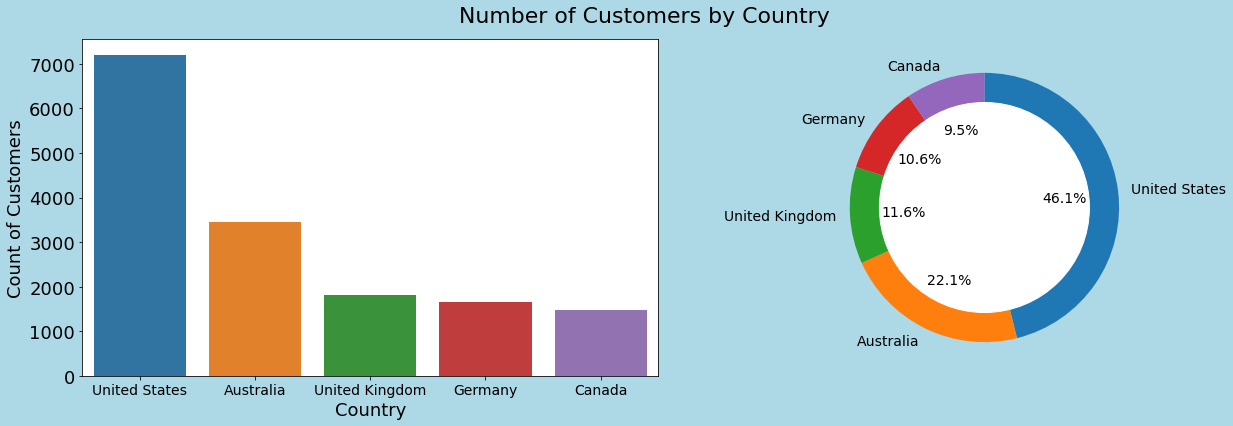

In [93]:
make_count_vis(country_count,'Country')

__Revenue by Country__

Revenue by Country Basic Statistics

In [94]:
make_basic_stats(customer_country_rev,'Country')

,TotalRevenue
count,7193.000000
mean,1099.193520
std,1521.125955
min,2.290000
25%,64.970000
50%,147.530000
75%,1839.920000
max,6536.910000
,TotalRevenue
count,3453.000000


Total, Mean and Median Revenue by Region

In [95]:
rev_by_country = make_agg_rev(customer_country_rev,'Country')
rev_by_country

,TotalRevenue,AverageRevenue,MedianRevenue
Country,,,
Australia,7365044.26,2132.940707,1272.97
United Kingdom,2882891.20,1592.757569,590.95
Germany,2504914.27,1509.894075,573.63
Canada,1749813.16,1179.119380,302.28
United States,7906498.99,1099.193520,147.53


Revenue by Country Visualization

                TotalRevenue  AverageRevenue  MedianRevenue
Country                                                    
Australia         7365044.26     2132.940707        1272.97
United Kingdom    2882891.20     1592.757569         590.95
Germany           2504914.27     1509.894075         573.63
Canada            1749813.16     1179.119380         302.28
United States     7906498.99     1099.193520         147.53


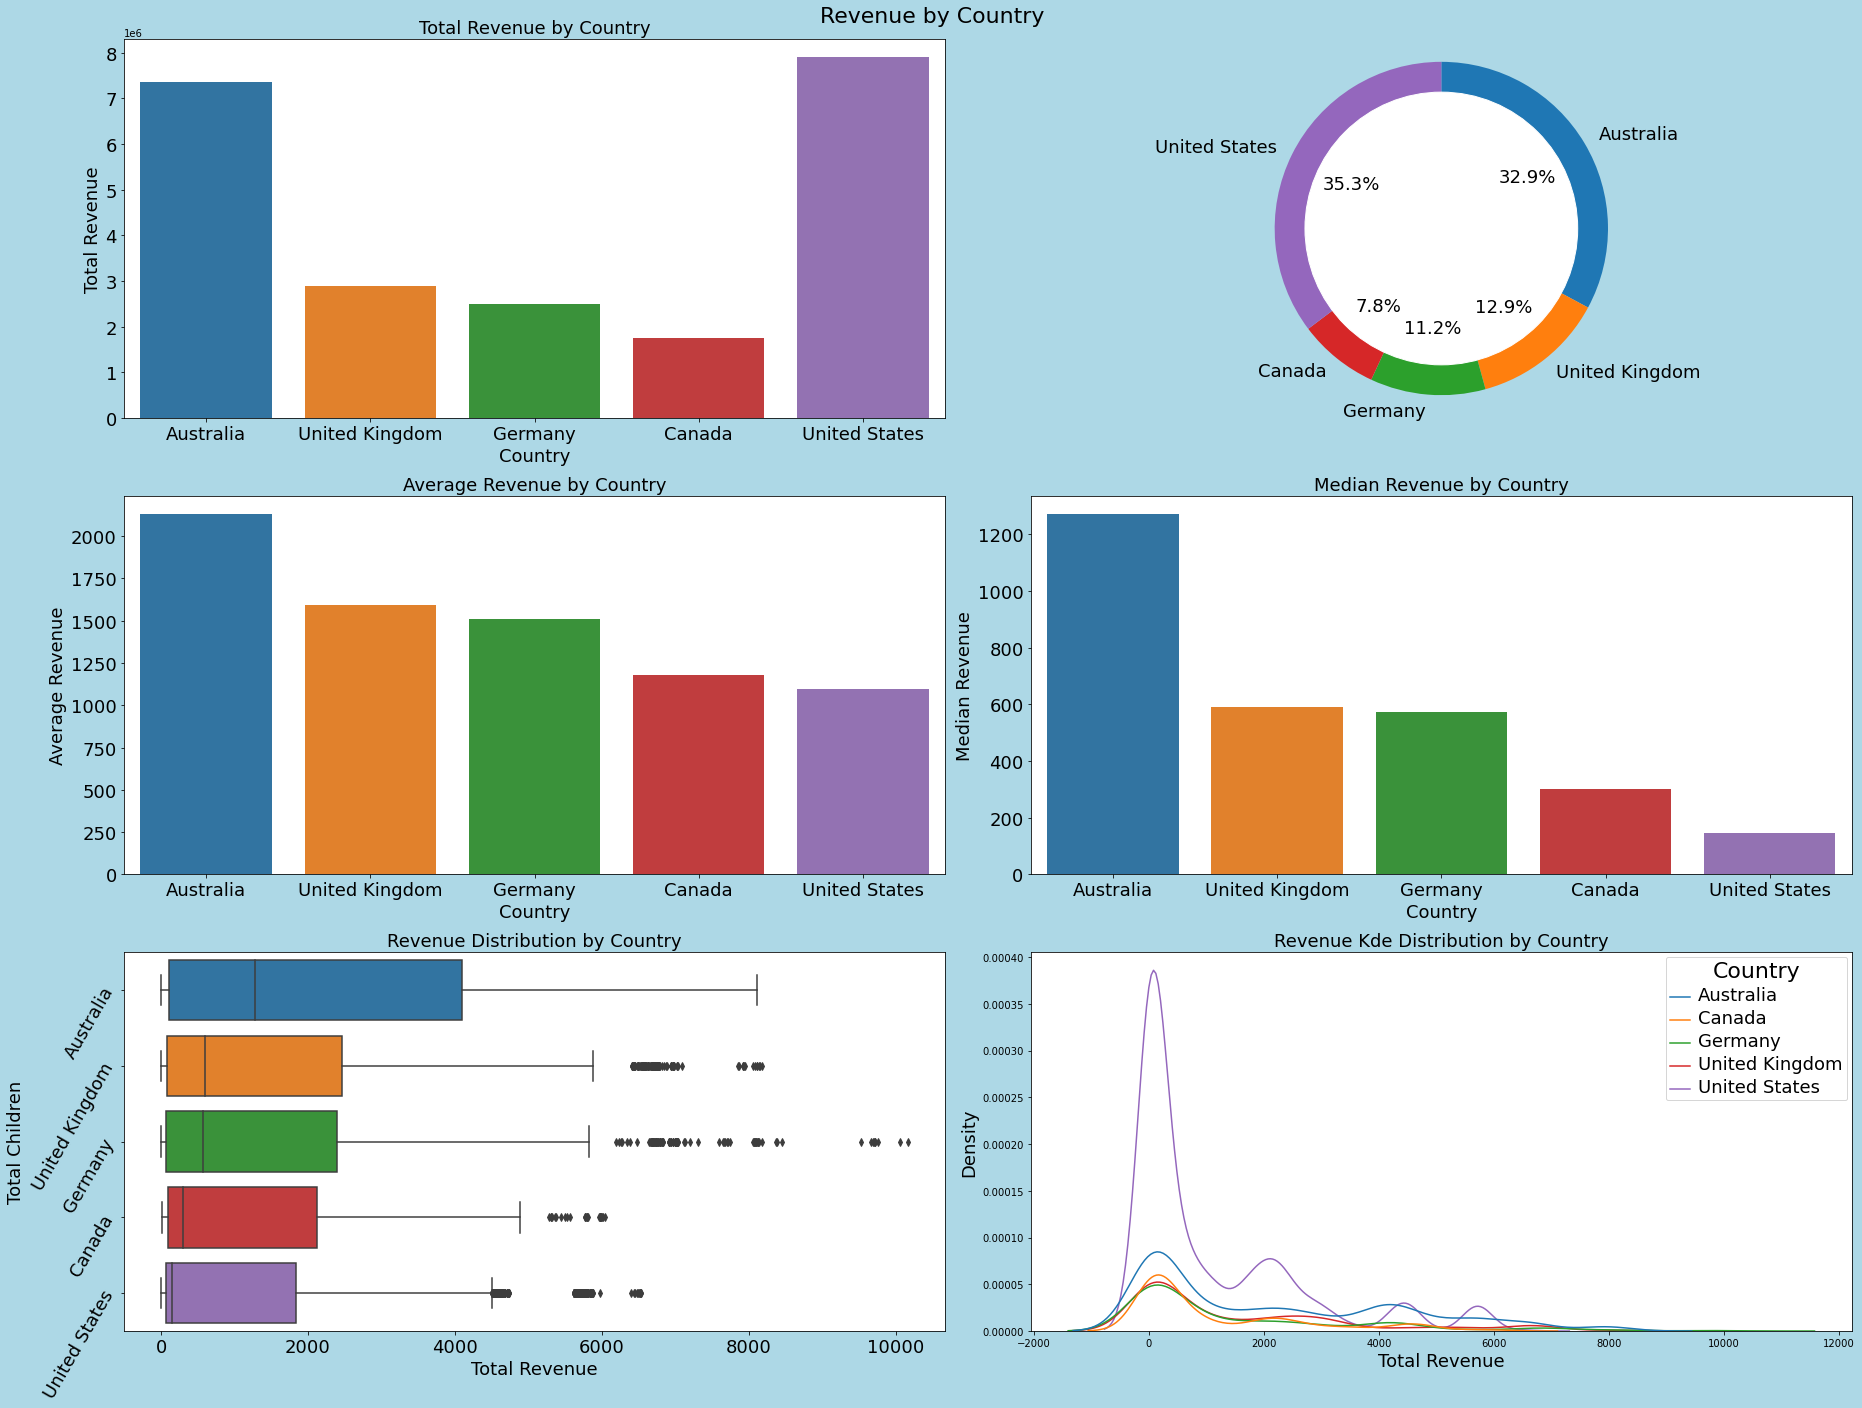

In [96]:
make_rev_vis(rev_by_country,customer_country_rev,'Country','Country')

Revenue vs. Region Significance\
Is there a significant evidence that customers from Southwest spend more than those from Southeast on aevrage?

In [97]:
make_stats_test(customer_country_rev,rev_by_country,'Country')

Statistics: 8.926907397125955
P_value 6.508597618933261e-19
There is a significant evidence that Australia customers spend more than United Kingdom customers on average


__Inference__\
Customers form USA comprise the largest segment, contirbute the most in the total revenue. However, there is significant evidence that Australia customers spend more on average.

In [98]:
del (customer_country_rev,country_count,rev_by_country)
gc.collect()

22862

____
## Answering Specific Business Request Questions
____

Q1- Provide the information for USA customers spent more than their regional average spent in a csv file and show the totla revenue for each region in the USA?

In [99]:
df = customer_analysis[customer_analysis['Country']=='United States'].\
        groupby(['CustomerKey','Region']).\
        agg({'Revenue':'sum'}).rename(columns={'Revenue':'TotalRevenue'})

df=df[df['TotalRevenue']!=0]
df.reset_index(inplace = True)

for region in df['Region'].value_counts().index:
    regional_avg = df[df['Region']==region]['TotalRevenue'].mean()
    regional_customer_keys = df[df['TotalRevenue']>regional_avg]['CustomerKey'].tolist()
    regional_customers_info = customers[customers['CustomerKey']. isin(regional_customer_keys)]
    regional_customers_info.to_csv(f'../results/{region}_customers_above_regional_average.csv',index=False)

In [100]:
del df
gc.collect()

0

Q- From the data available, is there an association between Gender and Homeownership?

In [101]:
test_df = customer_analysis.\
        groupby(['CustomerKey','Gender','HomeOwner']).\
        agg({'Revenue':'sum'})
test_df=test_df[test_df['Revenue']!=0]
test_df.reset_index(inplace = True)
test_df.drop(['CustomerKey','Revenue'], axis = 1, inplace=True)

# H0: There is no association between gender and homeownership
# Ha: There is an association between gender and homeownership
alpha = 0.05

cont_table = pd.crosstab(test_df['Gender'],test_df['HomeOwner'])
s,p_value,df,ev = stats.chi2_contingency(cont_table)
print('alpha: ',alpha)
print('p_value: ',p_value)
if p_value < alpha:
    print('There is an association between gender and homeownership')
else:
    print('There is no assocaition between gender and homeownership')

alpha:  0.05
p_value:  0.5377199693749878
There is no assocaition between gender and homeownership


In [102]:
del test_df,cont_table,alpha,p_value
gc.collect()

0

Q3- Provide a dahsboard that shows Total Revenue monthly timeline, Total Revenue by Region and top 10 Customers. Enable filtering by gender, marital status, and home_ownership?

In [103]:
# make the gender widget
gender = ipywidgets.Dropdown(options =gender_list,
                             value = 'All',
                             description = 'Gender',
                             disabled = False);
 # make the marital_status widget                       
marital_status = ipywidgets.Dropdown(options = maritalStatus_list,
                             value = 'All',
                             description = 'Marital Status',
                             disabled = False);

# make the home_ownership widget                        
home_ownership =  ipywidgets.Dropdown(options =home_ownership_list,
                                      value = 'All',
                                      description = 'Home Ownership',
                                      disabled = False);

# define the plotting of the AnnualIncome distribution
def dashboard(gender, marital_status,home_ownership):
    dashb_df = customer_analysis[customer_analysis['Country']=='United States']
    dashb_df = dashb_df.set_index('OrderDate',drop=False).sort_index().to_period('M')
    dashb_df.index.name = 'OrderPeriod'
    dashb_df.reset_index(inplace = True)
    dashb_df['OrderPeriod'] = dashb_df['OrderPeriod'].astype('str')
    
    if gender != 'All':
        dashb_df = dashb_df[dashb_df['Gender'] == gender]
    if marital_status != 'All':
        dashb_df = dashb_df[dashb_df['MaritalStatus']==marital_status]
    if home_ownership != 'All':
        dashb_df= dashb_df[dashb_df['HomeOwner'] == home_ownership]
    
    top20_customers = dashb_df.groupby('Customer').\
            agg({'Revenue':'sum'}).\
            rename(columns ={'Revenue':'TotalRevenue'}).\
            sort_values('TotalRevenue', ascending = False).\
            head(20)
    
    region_rev = dashb_df.groupby('Region').\
                agg({'Revenue':'sum'}).\
                rename(columns = {'Revenue':'TotalRevenue'}).\
                sort_values('TotalRevenue', ascending = False)
    region_rev = region_rev[region_rev['TotalRevenue'] != 0]
    southeast_central_northeast = (region_rev.loc['USA-NE'] + 
                                   region_rev.loc['USA-C'] + 
                                   region_rev.loc['USA-SE'])
    region_rev.drop(labels = ['USA-SE','USA-C','USA-NE'], axis = 0, inplace = True)
    region_rev.loc['USA-SE, USA-C & USA-NE']=southeast_central_northeast
   
    fig = plt.figure(figsize=(14,10), constrained_layout=True, facecolor = 'lightblue')
    fig.suptitle('Revenue Breakdown in USA', size =18)
    spec = fig.add_gridspec(2,3)
    
    ax1 = fig.add_subplot(spec[:, 0])
    ax1 = sns.barplot(y = top20_customers.index, x = 'TotalRevenue', 
                      data = top20_customers, color = 'blue')
    plt.title('Top 20 Customers by Revenue')
    for index, value in enumerate(top20_customers['TotalRevenue']):
        label = format(int(value),',')
        plt.annotate(label, xy=(value - 4700, index), color='white', size = 14)
        
    ax2 = fig.add_subplot(spec[0, 1:])
    ax2 = sns.lineplot(x ='OrderPeriod', y = 'Revenue', data = dashb_df, estimator='sum', ci=None)
    plt.title('Revenue Timeline')
    plt.ylabel('TotalRevenue')
    plt.xticks(rotation = 45)
    
    ax3 = fig.add_subplot(spec[1, 1:])
    ax3 = sns.barplot(x = region_rev.index, y = 'TotalRevenue', data = region_rev, ci = None)
    plt.title('Revenue by Region')
    for index, value in enumerate(region_rev['TotalRevenue']):
        label = format(int(value),',')
        plt.annotate(label, xy=(index-0.25, value-500), color='black')

#add interaction to the funtion
ipywidgets.interact(dashboard, 
                    gender = gender, 
                    marital_status = marital_status, 
                    home_ownership = home_ownership)

interactive(children=(Dropdown(description='Gender', options=('All', 'F', 'M'), value='All'), Dropdown(descrip…

<function __main__.dashboard(gender, marital_status, home_ownership)>

_____
## Customer RFM Analysis
____

In [104]:
rfm_df = customer_analysis.groupby(['CustomerKey','OrderNumber']).\
            agg({'Revenue':'sum','OrderDate':'max','AnnualIncome':'mean'}).\
            reset_index().\
            groupby('CustomerKey').\
            agg({'OrderNumber':'count','Revenue':'sum','OrderDate':'max','AnnualIncome':'mean'}).\
            reset_index().\
            rename(columns = {'OrderNumber':'Frequency','Revenue':'Monetary'})


rfm_df['Recency'] = (rfm_df['OrderDate'].max()-rfm_df['OrderDate'])

rfm_df['Recency'] = rfm_df['Recency'].astype(str).str.split(' ').str.get(0).astype(int)

rfm_df.head()

,CustomerKey,Frequency,Monetary,OrderDate,AnnualIncome,Recency
0,11000,2,4656.39,2016-11-04,90000.0,238
1,11001,2,2821.21,2017-06-12,60000.0,18
2,11002,2,4466.81,2016-08-27,60000.0,307
3,11003,2,4532.99,2016-11-11,70000.0,231
4,11004,2,4568.08,2016-11-02,80000.0,240


In [105]:
rfm_stats = rfm_df[['Frequency','Monetary','Recency']].describe()
rfm_stats

,Frequency,Monetary,Recency
count,15599.000000,15599.000000,15599.000000
mean,1.454773,1436.576824,157.402975
std,1.045381,1866.746228,117.645973
min,1.000000,2.290000,0.000000
25%,1.000000,72.540000,63.000000
50%,1.000000,557.970000,142.000000
75%,2.000000,2263.270000,233.000000
max,26.000000,10165.920000,911.000000


It can be seen that the 0.25 and 0.50 quantiles of the "Frequancy" column are the same...which causes difficulties in assign the Frequency-Score since there is no differnce in the values between the 0.25 and 0.50 quantiles (even if I remove the outliers). To meditate this issue, I divide the range of the 'Frequecny' over 4 and use this value to assign the  Frequency-Score

In [106]:
f_quarter = (rfm_df['Frequency'].max() - rfm_df['Frequency'].min())/4
f_quarter

6.25

In [107]:
rfm_quantiles = {
    'recency':{'0.25':rfm_stats.loc['25%','Recency'],'0.50':rfm_stats.loc['50%','Recency'],'0.75':rfm_stats.loc['75%','Recency']},
    'frequency':{'0.25':f_quarter,'0.50':(f_quarter*2),'0.75':(3*f_quarter)},
    'monetary':{'0.25':rfm_stats.loc['25%','Monetary'],'0.50':rfm_stats.loc['50%','Monetary'],'0.75':rfm_stats.loc['75%','Monetary']}
                }
rfm_quantiles

{'recency': {'0.25': 63.0, '0.50': 142.0, '0.75': 233.0},
 'frequency': {'0.25': 6.25, '0.50': 12.5, '0.75': 18.75},
 'monetary': {'0.25': 72.53999999999999, '0.50': 557.97, '0.75': 2263.27}}

In [108]:
# write a function that return the recency score based on the Recency value
def r_scroe(x):
    if x <= rfm_quantiles['recency']['0.25']:
        return 4
    elif x <= rfm_quantiles['recency']['0.50']:
        return 3
    elif x <= rfm_quantiles['recency']['0.75']:
        return 2
    else:
        return 1

# write a function that return the frequency score based on the Frequency value
def f_scroe(x):
    if x <= rfm_quantiles['frequency']['0.25']:
        return 1
    elif x <= rfm_quantiles['frequency']['0.50']:
        return 2
    elif x <= rfm_quantiles['frequency']['0.75']:
        return 3
    else:
        return 4

# write a function that return the moonetary score based on the Monetary value
def m_scroe(x):
    if x <= rfm_quantiles['monetary']['0.25']:
        return 1
    elif x <= rfm_quantiles['monetary']['0.50']:
        return 2
    elif x <= rfm_quantiles['monetary']['0.75']:
        return 3
    else:
        return 4

In [109]:
# get the r-score
rfm_df['R-Score'] = rfm_df['Recency'].apply(lambda x : r_scroe(x))
# get the f-score
rfm_df['F-Score'] = rfm_df['Frequency'].apply(lambda x : f_scroe(x))
# get the m-score
rfm_df['M-Score'] = rfm_df['Monetary'].apply(lambda x : m_scroe(x))
# get the RFM-Score
rfm_df['RFM-Score'] = (rfm_df['R-Score']*100) + (rfm_df['F-Score']*10) + (rfm_df['M-Score'])
# sort the values based on RFM-Score
rfm_df.sort_values('RFM-Score', ascending = False, inplace =True)

# make a new column 'RFM-Loyalty-Level' based on the RFM-Score
loyalty_level = ['Bronze','Silver','Gold','Platinum']
score_cuts = pd.qcut(rfm_df['RFM-Score'],4,loyalty_level)
rfm_df['RFM-Loyalty-Level'] = score_cuts
rfm_df.head()

,CustomerKey,Frequency,Monetary,OrderDate,AnnualIncome,Recency,R-Score,F-Score,M-Score,RFM-Score,RFM-Loyalty-Level
261,11277,24,1776.68,2017-05-26,80000.0,35,4,4,3,443,Platinum
85,11091,26,1513.14,2017-06-23,90000.0,7,4,4,3,443,Platinum
168,11176,24,1526.01,2017-05-24,90000.0,37,4,4,3,443,Platinum
177,11185,25,1716.75,2017-06-15,70000.0,15,4,4,3,443,Platinum
260,11276,23,1111.21,2017-06-26,80000.0,4,4,4,3,443,Platinum


In [110]:
for level in loyalty_level:
    level_customers = rfm_df[rfm_df['RFM-Loyalty-Level'] == level]['CustomerKey']
    level_customers = customers[customers['CustomerKey'].isin(level_customers)]
    level_customers.to_csv(f'../results/{level}_customers.csv', index = False)